In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import LinearSVR
import xgboost as xgb

from sklearn.multioutput import MultiOutputRegressor

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

from scipy.stats import ttest_1samp, uniform, randint, linregress, ttest_ind
from scipy import stats
from statsmodels.stats import weightstats as stests

In [3]:
plt.style.use('seaborn')

In [4]:
%run CoreFunction.ipynb

In [5]:
TEST_SIZE=0.15
n_comp = 0.95

In [6]:
scaler_min_max = MinMaxScaler()
scaler_z_score = StandardScaler()

In [7]:
def min_max_normalize(data):
    n_data = (data - data.min()) / (data.max() - data.min())
    return n_data

In [8]:
def z_score_normalize(raw_data):
    mean = raw_data.mean(axis=0)
    raw_data -= mean
    std = raw_data.std(axis=0)
    raw_data /= std
    
    return raw_data

In [9]:
load_target, load_attribute, df_data_load = read_data("total load actual",  r"data\df_data_load_ts720_120_24.csv")

Моделът на гаусовата смес (GaussianMixture) е вероятностен модел, който предполага, че всички точки от данни са генерирани от комбинация от гаусови разпределения с неизвестни параметри. GaussianMixture може да се използва за клъстериране.  Тъй като таргетната променлива има подчертан бимодален характер ще проверим дали не може да бъде разложена на гаусови разпределения. Първо ще проверим, на колко разпределения може да бъде разложена. 

За целта ще използваме информационния критерий на Akaike (AIC) и байесовия информационен критерий (BIC). Това са аналитични критетии, 

Информационният критерий на Akaike (AIC) е математически метод за оценка на това колко добре даден модел отговаря на данните, от които е генериран. AIC се изчислява от:

- броя на независимите променливи, използвани за изграждане на модела.
- оценката на максималната вероятност на модела (колко добре моделът възпроизвежда данните).

Най-подходящият модел според AIC е този, който обяснява най-голямото количество вариации, използвайки възможно най-малко независими променливи. 


„Информационният критерий на Akaike“ е относителна мярка за качеството на модел за даден набор от данни и помага при избора на модел сред краен набор от модели. Той използва оценката на максималната вероятност и броя на параметрите, за да оцени информацията, загубена в модела. Мярката AIC дава компромис между точността на модела и сложността на модела. Така че, с други думи, това ни предпазва от овърфитинг. 


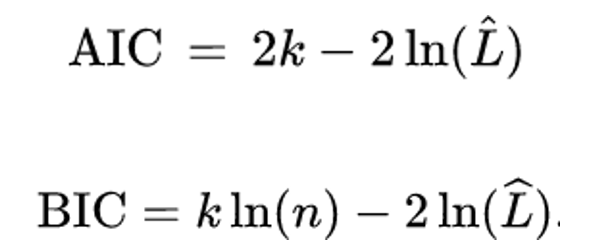

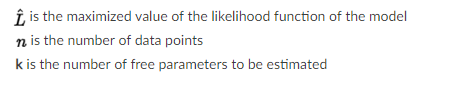

BIC е подобен на AIC, но въвеждана по-голямо "наказание"(penalty) за броя на параметрите в модела. Penalty е по-голям в BIC, отколкото в AIC. 
Въпреки че BIC винаги е по-висок от AIC, по-ниска е стойността на тези две мерки, по-добър модел. 

На долната графика е видно, че е оптимално да проверим с n_components = 3

In [10]:
# load_actual = pd.DataFrame(z_score_normalize(df_data_load['total load actual']))

In [11]:
load_attribute_scaled = z_score_normalize(load_attribute)

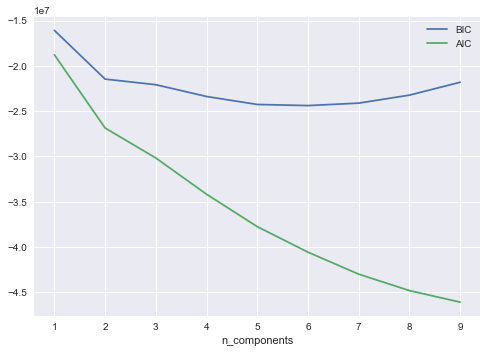

In [15]:
n_components = np.arange(1, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(load_attribute_scaled)
          for n in n_components]

plt.plot(n_components, [m.bic(load_attribute_scaled) for m in models], label='BIC')
plt.plot(n_components, [m.aic(load_attribute_scaled) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [12]:
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(load_attribute_scaled)
labels = gmm.predict(load_attribute_scaled)

In [13]:
# gmm.means_, gmm.covariances_, 

In [14]:
gmm.weights_, gmm.lower_bound_

(array([0.49552655, 0.50447345]), 411.3193863377879)

In [15]:
df_data_load['cluster']=labels

In [16]:
df_data_load_distribution_0 = df_data_load[df_data_load["cluster"]==0]
df_data_load_distribution_1 = df_data_load[df_data_load["cluster"]==1]

In [17]:
def get_data(df_data, col_name):
    target_cols = [col for col in df_data.columns if 'Target' in col]
    target = df_data[target_cols]       
    attribute = df_data.drop(["time", "cluster", col_name], axis = 1)
    attribute = attribute.drop(target_cols, axis = 1)
    return target, attribute, df_data

In [18]:
target_0, attribute_0, df_data_0 = get_data(df_data_load_distribution_0, "total load actual")

In [19]:
target_1, attribute_1, df_data_1 = get_data(df_data_load_distribution_1, "total load actual")

In [20]:
target_0.shape, attribute_0.shape,

((16948, 120), (16948, 798))

In [21]:
target_1.shape, attribute_1.shape,

((17254, 120), (17254, 798))

In [22]:
load_atribute_train_0, load_atribute_test_0, load_target_train_0, load_target_test_0, load_attribute_col_names_0 = scaled_data(target_0, attribute_0, TEST_SIZE, scaler_z_score)
load_atribute_train_1, load_atribute_test_1, load_target_train_1, load_target_test_1, load_attribute_col_names_1 = scaled_data(target_1, attribute_1, TEST_SIZE, scaler_z_score)

In [31]:
load_linear_regression_0 = LinearRegression().fit(load_atribute_train_0, load_target_train_0)
load_linear_regression_1 = LinearRegression().fit(load_atribute_train_1, load_target_train_1)

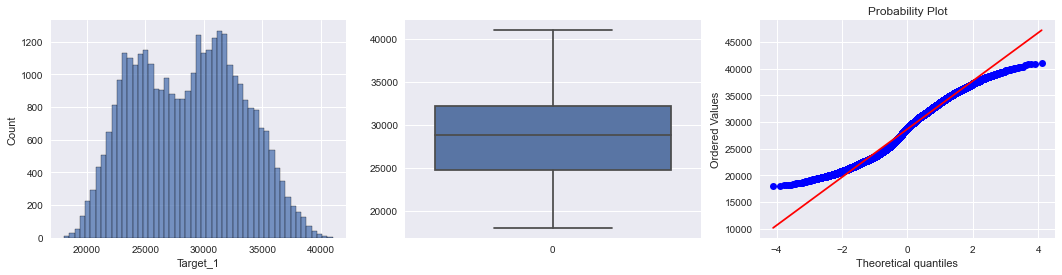

In [32]:
for i in range(1, 2):
    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
    sns.histplot(data = load_target[f"Target_{i}"], ax=ax[0])
    sns.boxplot(data = load_target[f"Target_{i}"], ax=ax[1])
    stats.probplot(load_target[f"Target_{i}"], plot=ax[2])
    plt.show()

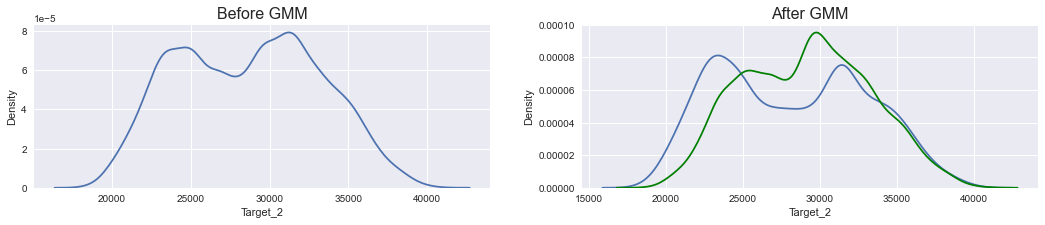

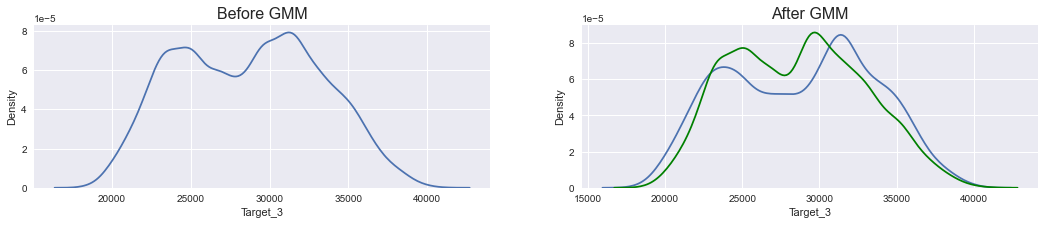

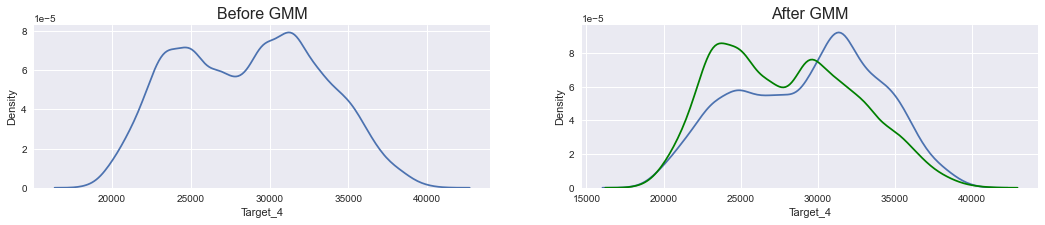

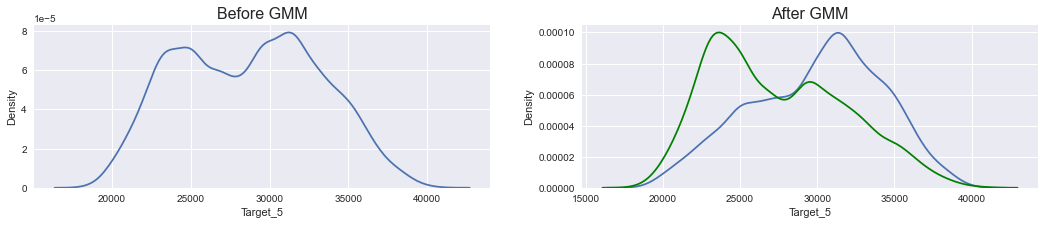

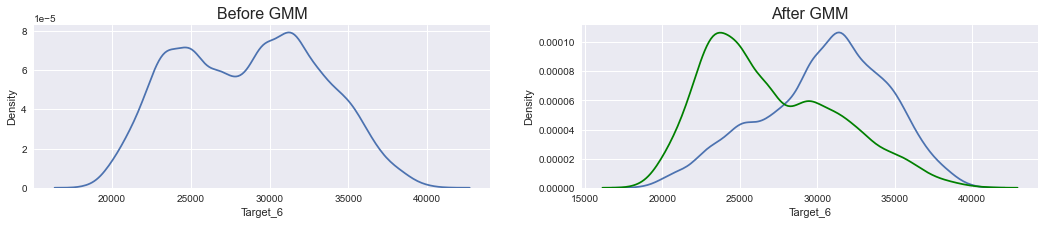

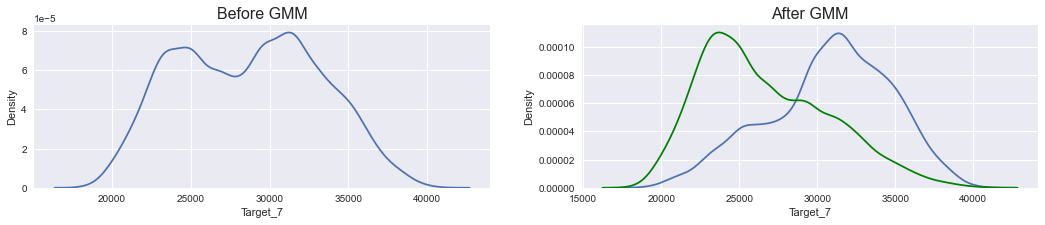

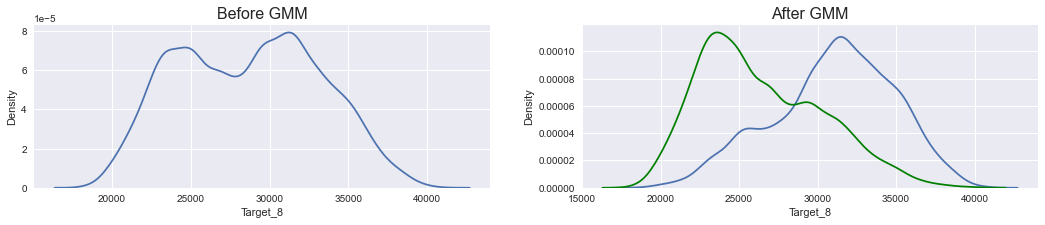

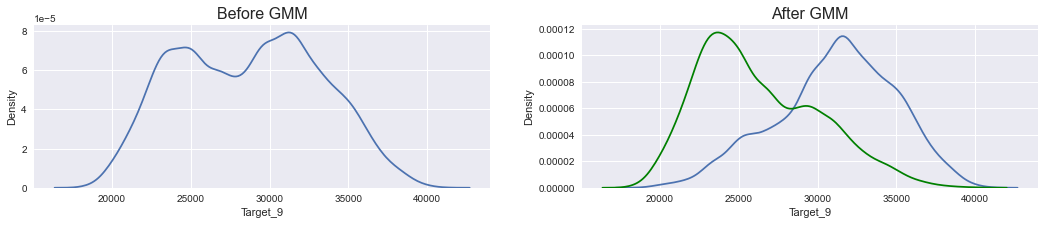

In [33]:
for i in range(2, 10):   #range(5, 6)
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 3))
    sns.kdeplot(data=load_target[f"Target_{i}"], ax=ax[0])
    ax[0].set_title('Before GMM', fontsize=16)
    sns.kdeplot(data=load_target_train_0[f"Target_{i}"], label='Component 1', ax=ax[1])
    sns.kdeplot(data=load_target_train_1[f"Target_{i}"], label='Component 2', color = 'g', ax=ax[1])
    ax[1].set_title('After GMM', fontsize=16)
    plt.show()

# https://www.kaggle.com/code/iamleonie/handling-multimodal-distributions-fe-techniques

In [34]:
len(load_atribute_test_0), len(load_atribute_train_0), len(load_atribute_test_1), len(load_atribute_train_1)

(2543, 14405, 2589, 14665)

In [35]:
lp_0 = load_linear_regression_0.predict(load_atribute_test_0)
lp_1 = load_linear_regression_1.predict(load_atribute_test_1)

In [36]:
_, _, _ = evaluation_report(load_linear_regression_0, load_atribute_train_0, load_target_train_0)

Score Results:
Mean squared error: 6204941.79
Root mean squared error: 2468.79
Mean absolute error: 1874.66
Coefficient of determination: 0.6376
Predicted mean: 28681.978 (3809.759)


In [37]:
_, _, _ = evaluation_report(load_linear_regression_0, load_atribute_test_0, load_target_test_0)

Score Results:
Mean squared error: 7140912.53
Root mean squared error: 2649.76
Mean absolute error: 2008.43
Coefficient of determination: 0.5887
Predicted mean: 28724.469 (3829.095)


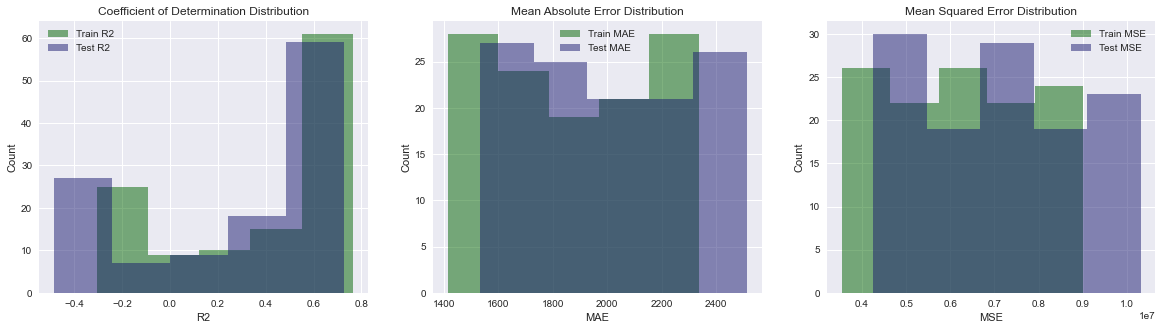

In [45]:
r2_train_0, r2_test_0, mae_train_0, mae_test_0, mse_train_0, mse_test_0 = generate_score_distributions(load_linear_regression_0, load_atribute_train_0, load_target_train_0, load_atribute_test_0, load_target_test_0)

In [48]:
pv_r2_ttest_0 = get_ttest_2samples(r2_train_0, r2_test_0)
pv_mae_ttest_0 = get_ttest_2samples(mae_train_0, mae_test_0)
pv_mse_ttest_0 = get_ttest_2samples(mse_train_0, mse_test_0)

p-value: 0.0879160093451866
fail to reject the null hypothesis
p-value: 0.0004445953481711088
we are rejecting null hypothesis
p-value: 4.143363856560421e-05
we are rejecting null hypothesis


In [49]:
pv_r2_ztest_0 = get_ztest_2samples(r2_train_0, r2_test_0)
pv_mae_ztest_0 = get_ztest_2samples(mae_train_0, mae_test_0)
pv_mse_ztest_0 = get_ztest_2samples(mse_train_0, mse_test_0)

p-value: 0.0866139210725217
fail to reject the null hypothesis
p-value: 0.00036816347555782914
reject null hypothesis
p-value: 2.9500466799302248e-05
reject null hypothesis


In [38]:
_, _, _ = evaluation_report(load_linear_regression_1, load_atribute_train_1, load_target_train_1)

Score Results:
Mean squared error: 6275263.15
Root mean squared error: 2481.80
Mean absolute error: 1882.40
Coefficient of determination: 0.6369
Predicted mean: 28660.732 (3798.531)


In [39]:
_, _, _ = evaluation_report(load_linear_regression_1, load_atribute_test_1, load_target_test_1)

Score Results:
Mean squared error: 7043037.31
Root mean squared error: 2630.52
Mean absolute error: 1991.78
Coefficient of determination: 0.5916
Predicted mean: 28661.894 (3815.745)


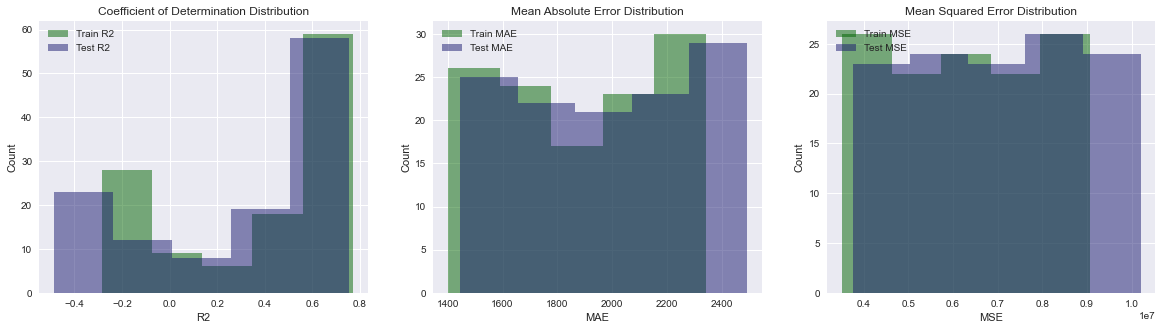

In [51]:
r2_train_1, r2_test_1, mae_train_1, mae_test_1, mse_train_1, mse_test_1 = generate_score_distributions(load_linear_regression_1, load_atribute_train_1, load_target_train_1, load_atribute_test_1, load_target_test_1)

In [53]:
pv_r2_ttest_1 = get_ttest_2samples(r2_train_1, r2_test_1)
pv_mae_ttest_1 = get_ttest_2samples(mae_train_1, mae_test_1)
pv_mse_ttest_1 = get_ttest_2samples(mse_train_1, mse_test_1)

p-value: 0.11476923920825562
fail to reject the null hypothesis
p-value: 0.00480479180964055
we are rejecting null hypothesis
p-value: 0.0008763680055472725
we are rejecting null hypothesis


In [54]:
pv_r2_ztest_1 = get_ztest_2samples(r2_train_1, r2_test_1)
pv_mae_ztest_1 = get_ztest_2samples(mae_train_1, mae_test_1)
pv_mse_ztest_1 = get_ztest_2samples(mse_train_1, mse_test_1)

p-value: 0.1134413299782998
fail to reject the null hypothesis
p-value: 0.004419088585393596
reject null hypothesis
p-value: 0.0007512463952991106
reject null hypothesis


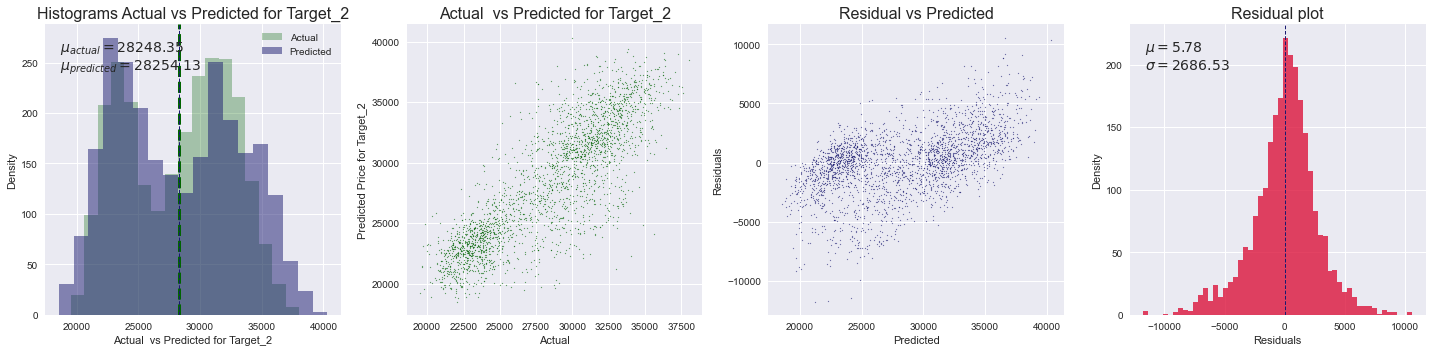

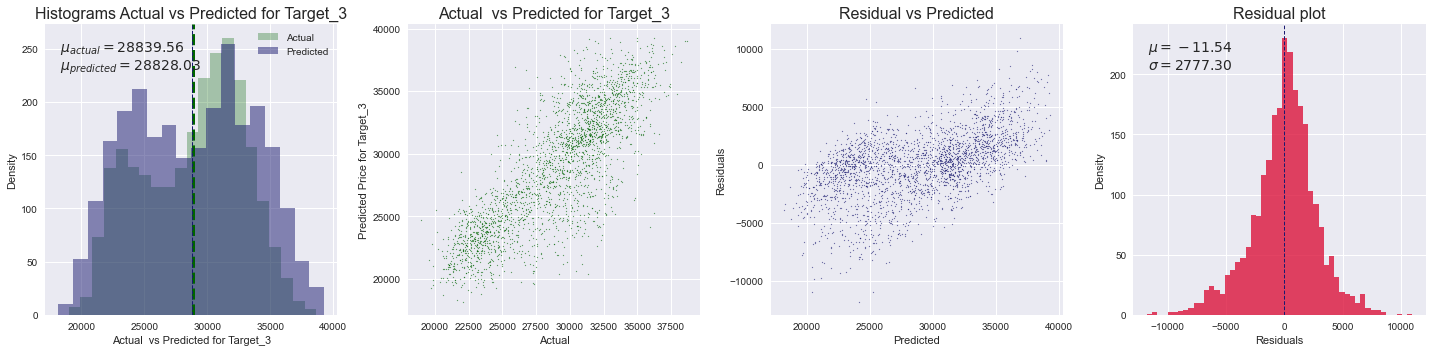

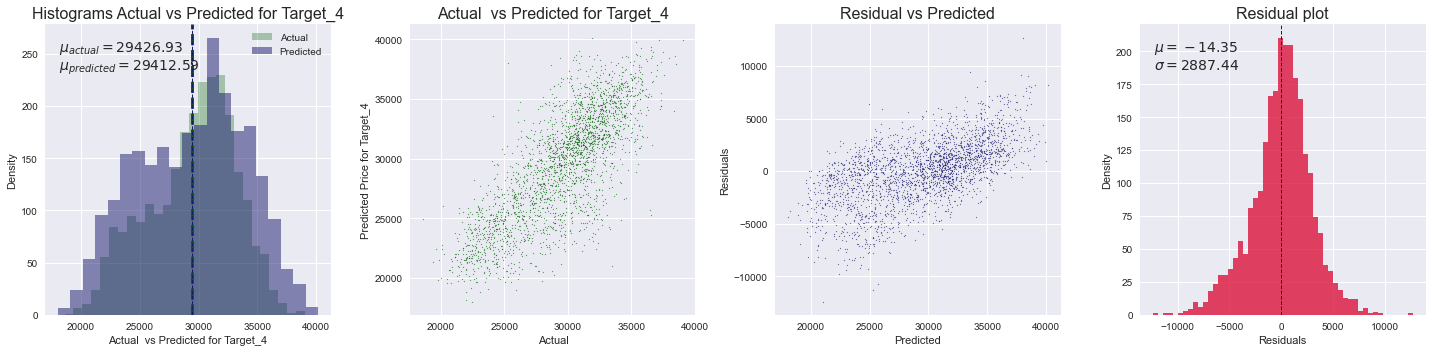

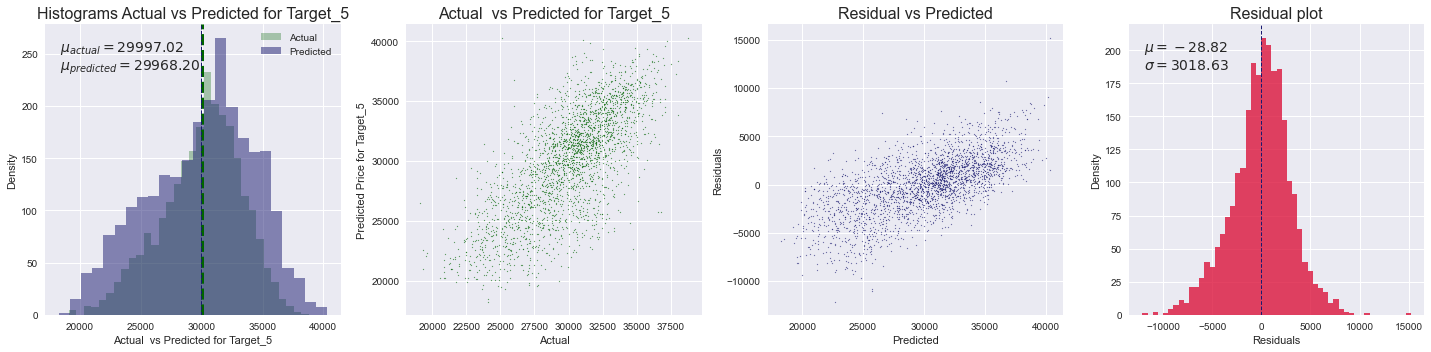

In [44]:
load_prediction_0 = load_linear_regression_0.predict(load_atribute_test_0)
e_minus_o_l_0 = get_and_plot_data(load_prediction_0, load_target_test_0, start_index=1, stop_index=5)

In [56]:
print(get_ttest (load_prediction_0, load_target_test_0, idx=10))

p-value: 0.986291113885496
we are accepting null hypothesis


In [59]:
print(get_ztest (load_prediction_0, load_target_test_0, idx=10))

p-value: 0.9862897653156123
accept null hypothesis


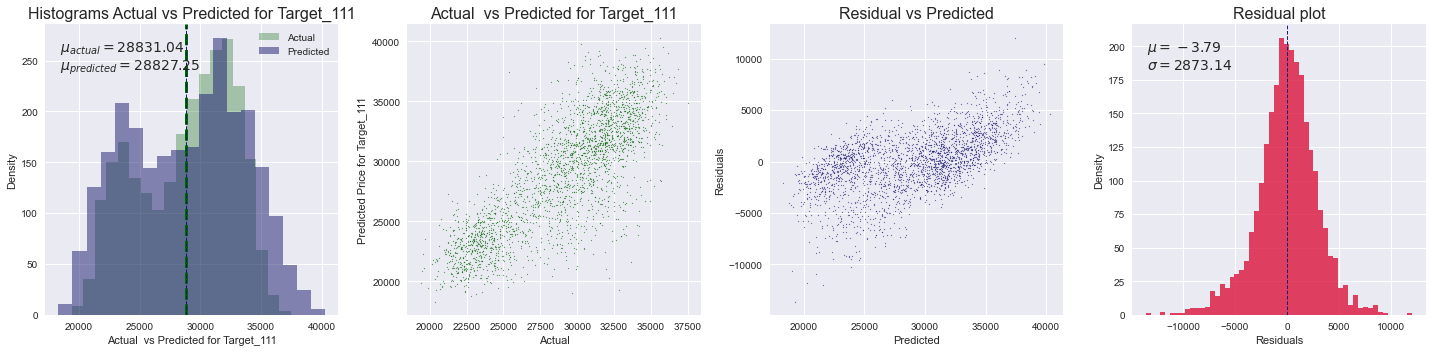

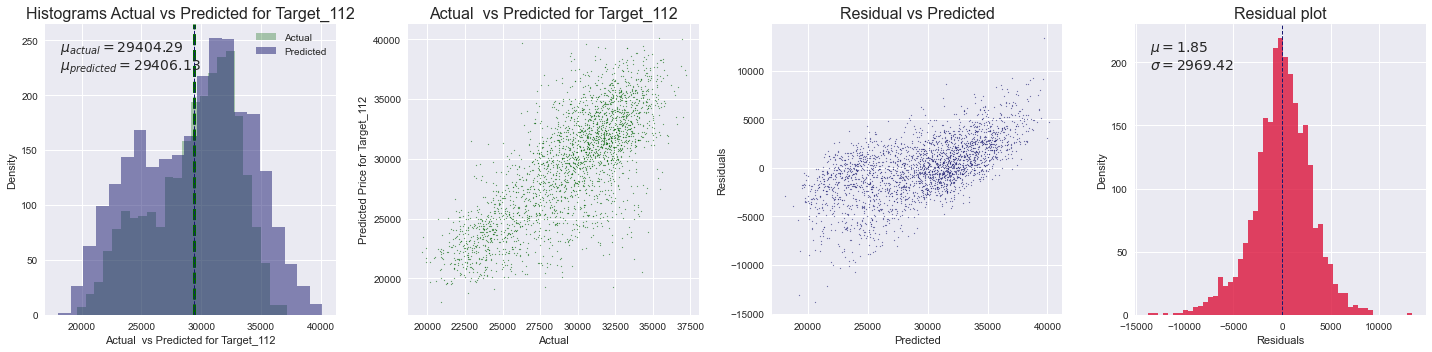

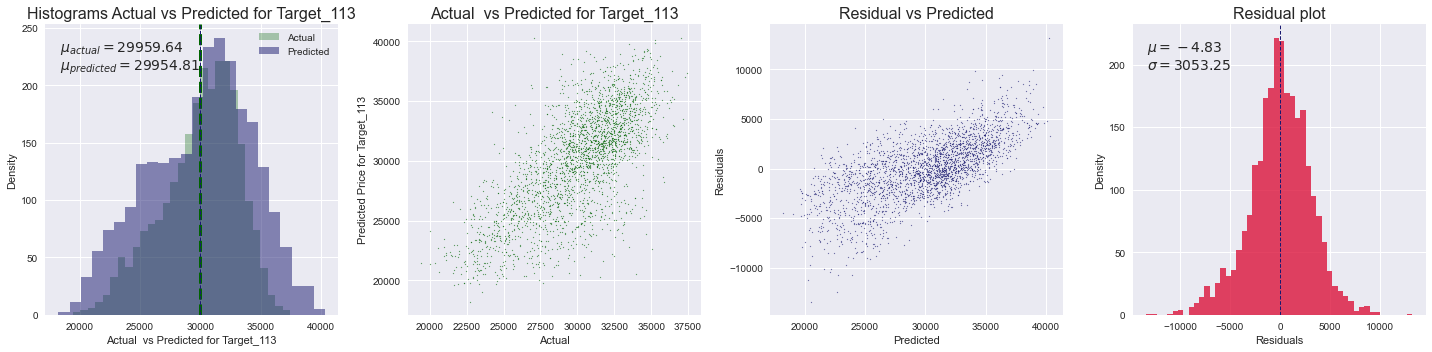

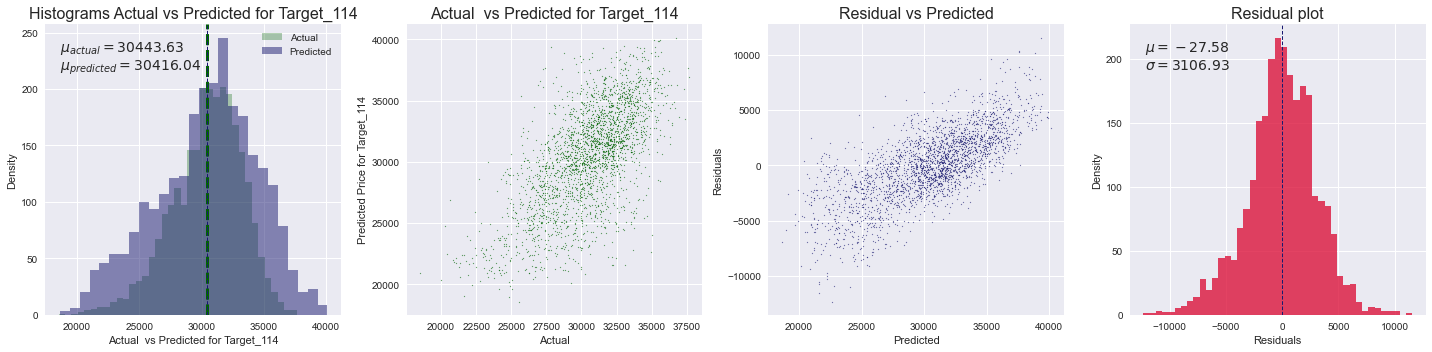

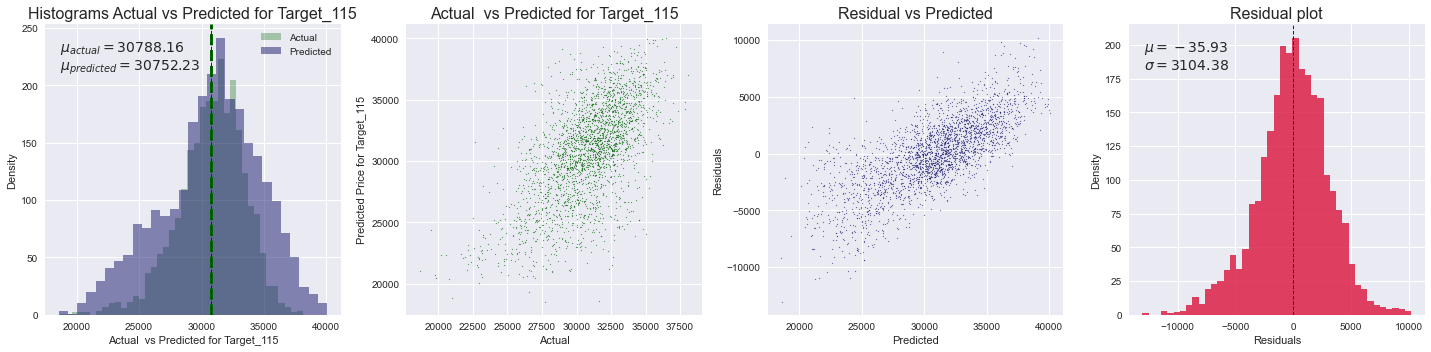

In [41]:
load_prediction_1 = load_linear_regression_1.predict(load_atribute_test_1)
e_minus_o_l_1 = get_and_plot_data(load_prediction_1, load_target_test_1, start_index=110, stop_index=115)

In [60]:
print(get_ttest (load_prediction_1, load_target_test_1, idx=10))

p-value: 0.018794894507272692
we are rejecting null hypothesis


In [61]:
print(get_ztest (load_prediction_1, load_target_test_1, idx=10))

p-value: 0.01872026156607355
reject null hypothesis


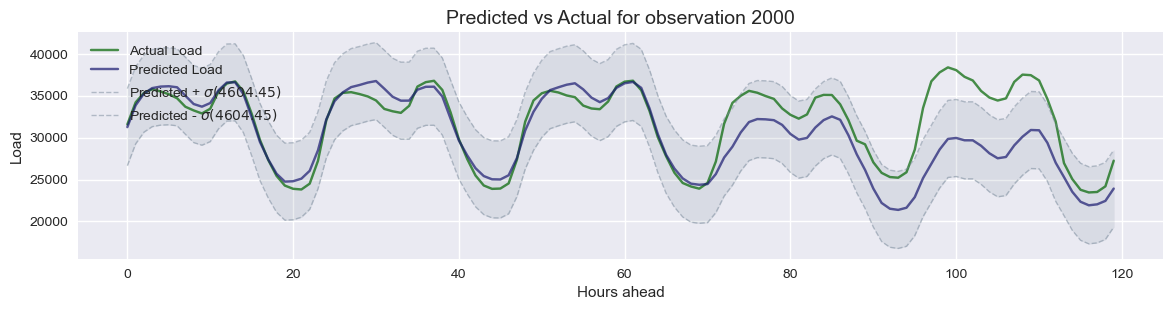

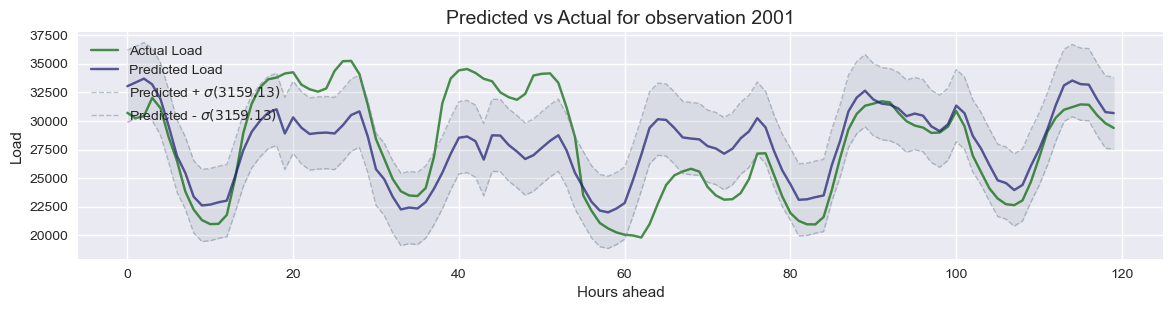

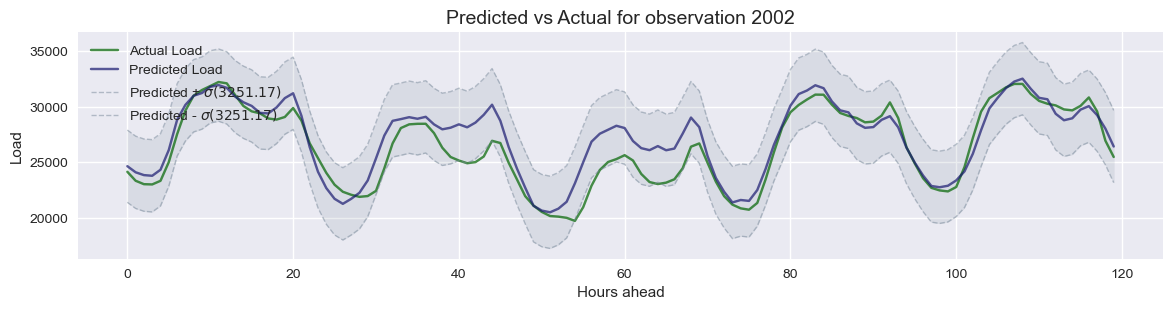

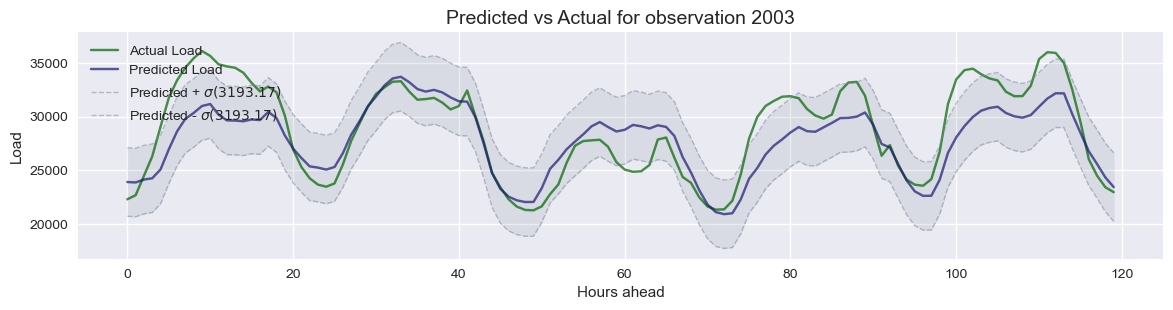

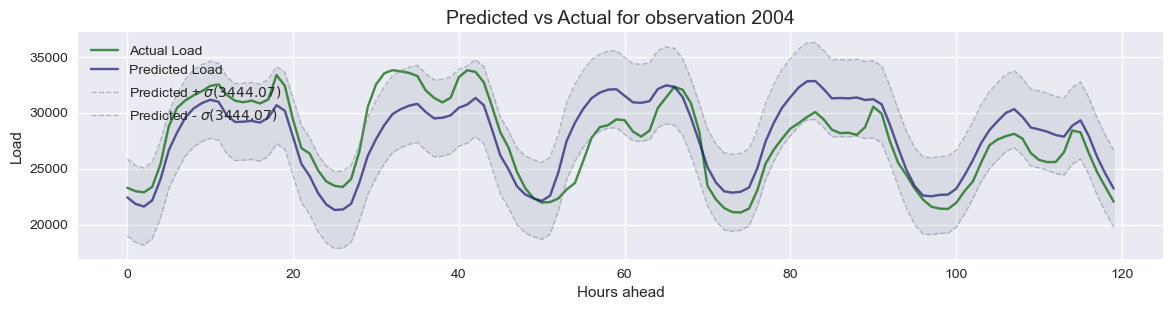

In [62]:
plot_actual_vs_prediction(load_prediction_0, load_target_test_0, variable_name = 'Load', start_inx = 2000, end_inx = 2005)
# beteen 0 and 2543 ----> count of observations in len(load_target_test_0)

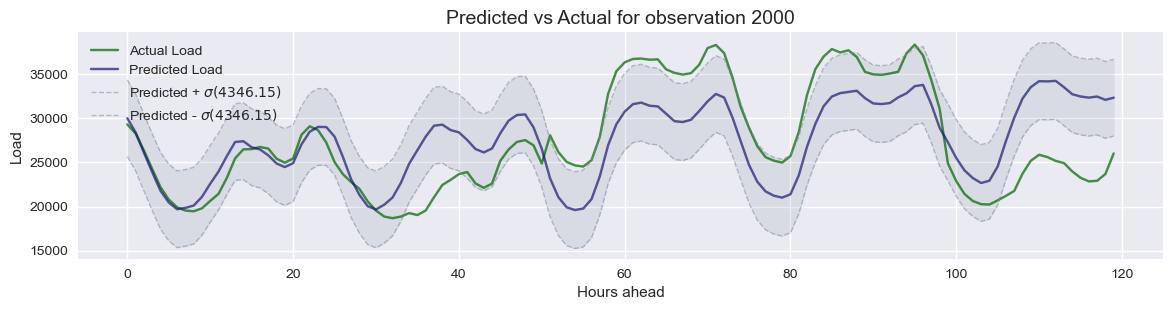

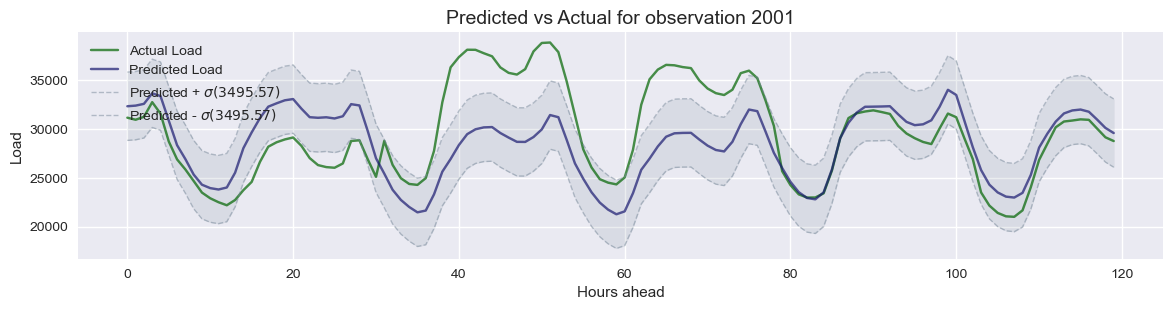

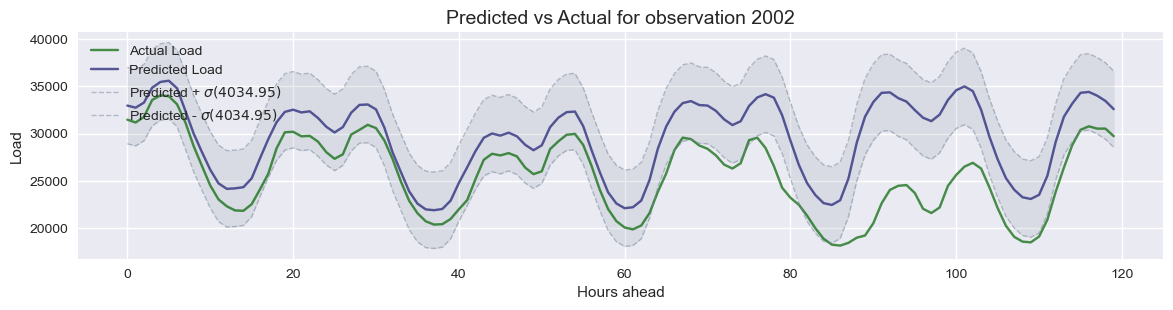

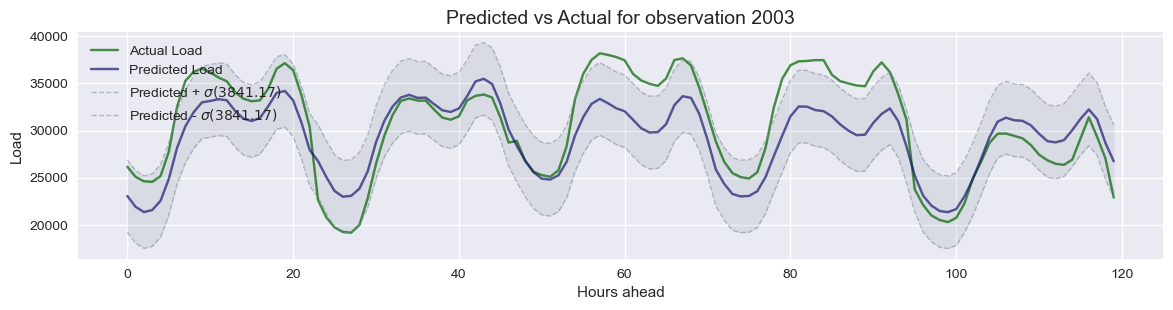

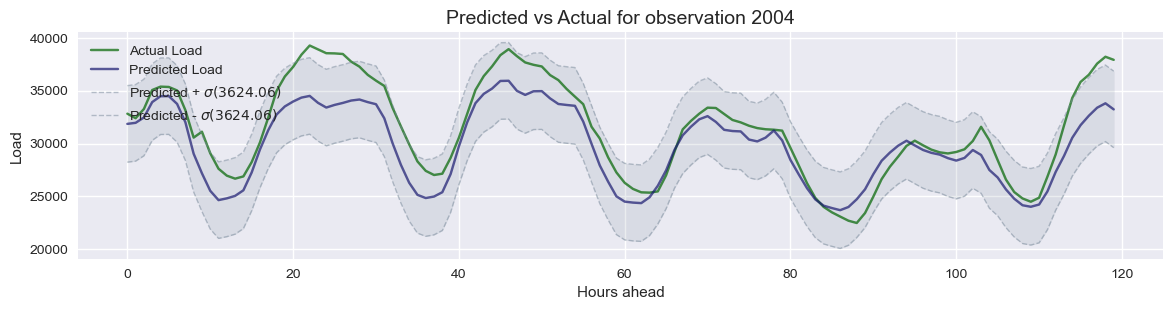

In [66]:
plot_actual_vs_prediction(load_prediction_1, load_target_test_1, variable_name = 'Load', start_inx = 2000, end_inx = 2005)
# beteen 0 and 2589 ----> count of observations in len(load_target_test_1)

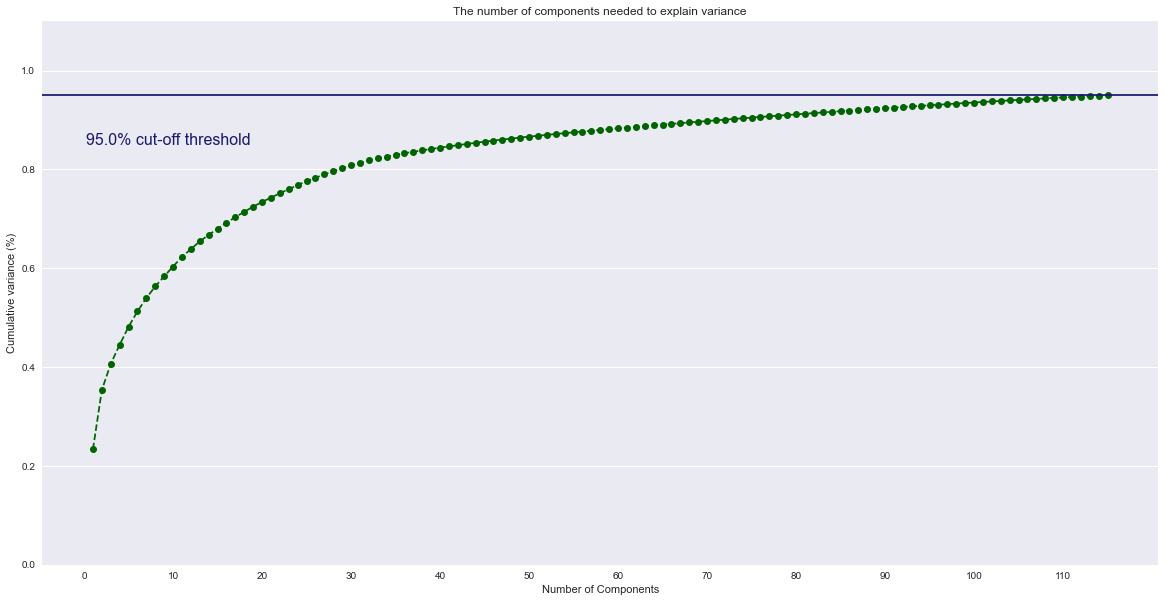

Transformed train shape: (14405, 115)
Transformed test shape: (2543, 115)
Function took 1.4274 seconds


In [81]:
most_important_features_0, PC_train_0, PC_test_0 = PCA_feature_preprocessing(load_atribute_train_0, load_atribute_test_0, n_comp = n_comp, col_names = attribute_0.columns)

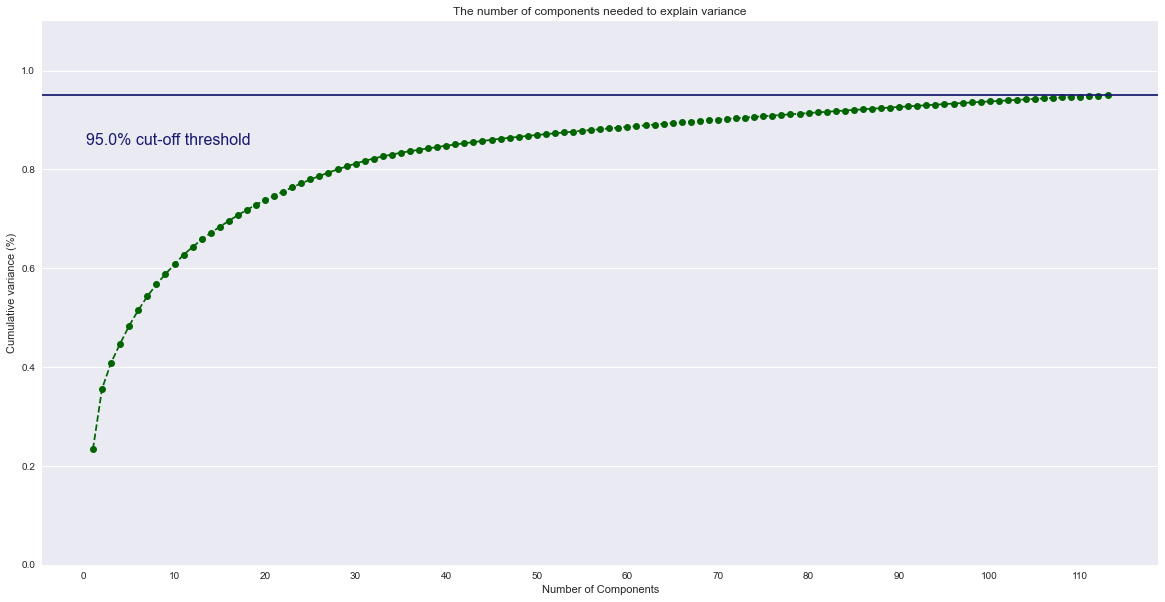

Transformed train shape: (14665, 113)
Transformed test shape: (2589, 113)
Function took 1.5775 seconds


In [83]:
most_important_features_1, PC_train_1, PC_test_1 = PCA_feature_preprocessing(load_atribute_train_1, load_atribute_test_1, n_comp = n_comp, col_names = attribute_1.columns)

In [70]:
svr = LinearSVR(C=1, max_iter = 1000, tol = 0.001, random_state=42,  loss='squared_epsilon_insensitive', dual=False)

@timeit
def ada_svr(estimator, att, target):
    ada_boost = AdaBoostRegressor(base_estimator = estimator, n_estimators = 10, learning_rate = 1)
    ada_wrapped = MultiOutputRegressor(estimator=ada_boost)
    ada_wrapped.fit(att, target)
    return ada_wrapped

ada_wrapped_svr_0 = ada_svr(svr, load_atribute_train_0, load_target_train_0)

Function took 5312.8570 seconds


In [71]:
save_model(ada_wrapped_svr_0, "#ada_load_wrapped_svr_gmm_0.sav")

In [ ]:
ada_wrapped_svr_0=load_model("#ada_load_wrapped_svr_gmm_0.sav")

In [72]:
_, _, _ = evaluation_report(ada_wrapped_svr_0, load_atribute_train_0, load_target_train_0)

Score Results:
Mean squared error: 6716897.72
Root mean squared error: 2571.14
Mean absolute error: 2046.72
Coefficient of determination: 0.6083
Predicted mean: 28543.410 (3693.624)


In [73]:
_, _, _ = evaluation_report(ada_wrapped_svr_0, load_atribute_test_0, load_target_test_0)

Score Results:
Mean squared error: 7672710.91
Root mean squared error: 2748.86
Mean absolute error: 2159.19
Coefficient of determination: 0.5588
Predicted mean: 28580.382 (3711.184)


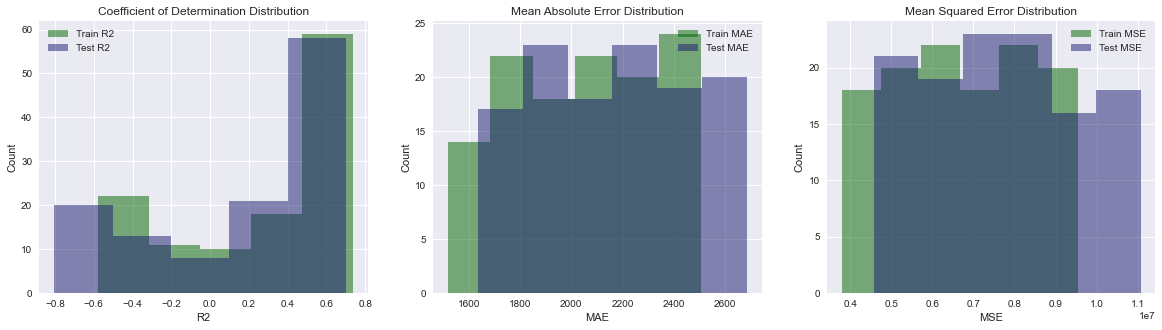

In [74]:
r2_train_0, r2_test_0, mae_train_0, mae_test_0, mse_train_0, mse_test_0 = generate_score_distributions(ada_wrapped_svr_0, load_atribute_train_0, load_target_train_0, load_atribute_test_0, load_target_test_0)

In [75]:
pv_r2_ttest_0 = get_ttest_2samples(r2_train_0, r2_test_0)
pv_mae_ttest_0 = get_ttest_2samples(mae_train_0, mae_test_0)
pv_mse_ttest_0 = get_ttest_2samples(mse_train_0, mse_test_0)

p-value: 0.1114483216512645
fail to reject the null hypothesis
p-value: 0.002916624605418464
we are rejecting null hypothesis
p-value: 4.218431135045036e-05
we are rejecting null hypothesis


In [76]:
pv_r2_ztest_0 = get_ztest_2samples(r2_train_0, r2_test_0)
pv_mae_ztest_0 = get_ztest_2samples(mae_train_0, mae_test_0)
pv_mse_ztest_0 = get_ztest_2samples(mse_train_0, mse_test_0)

p-value: 0.11012152679250252
fail to reject the null hypothesis
p-value: 0.002633966493137597
reject null hypothesis
p-value: 3.007465925681518e-05
reject null hypothesis


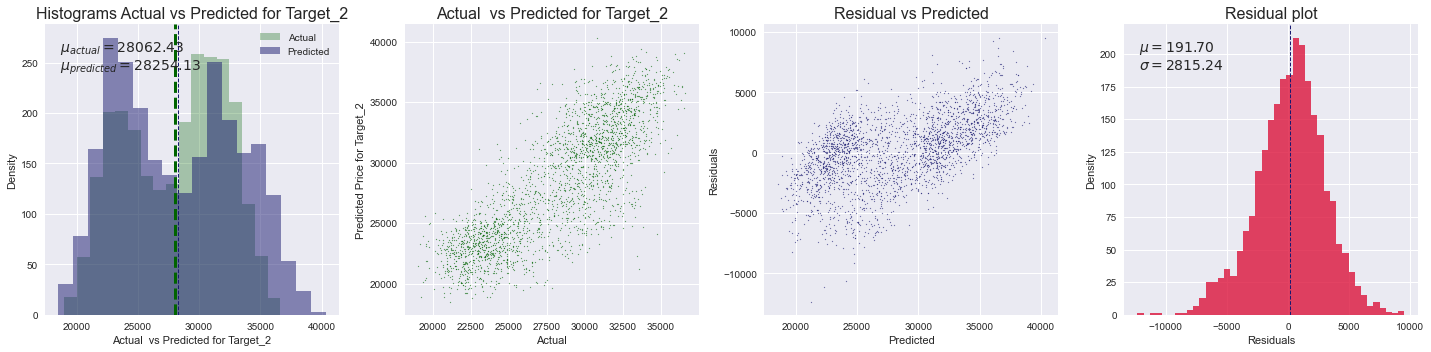

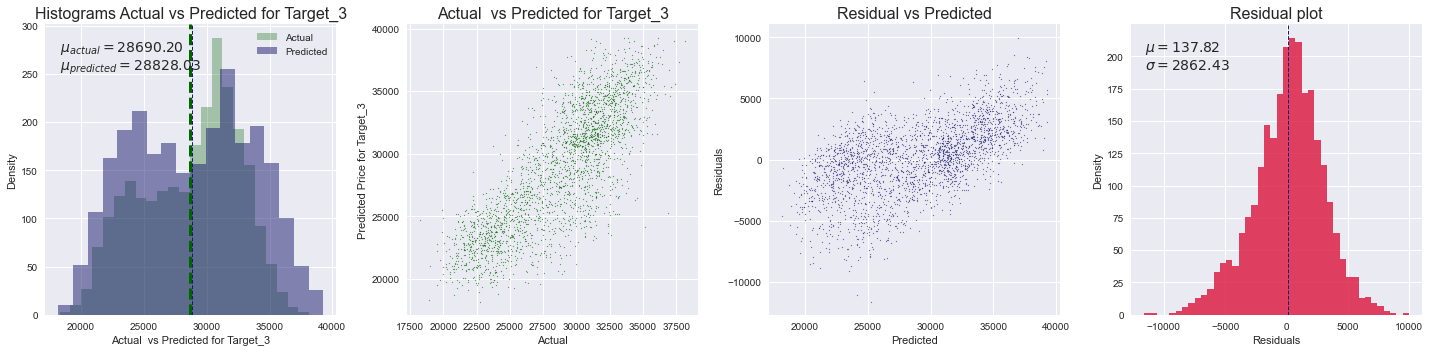

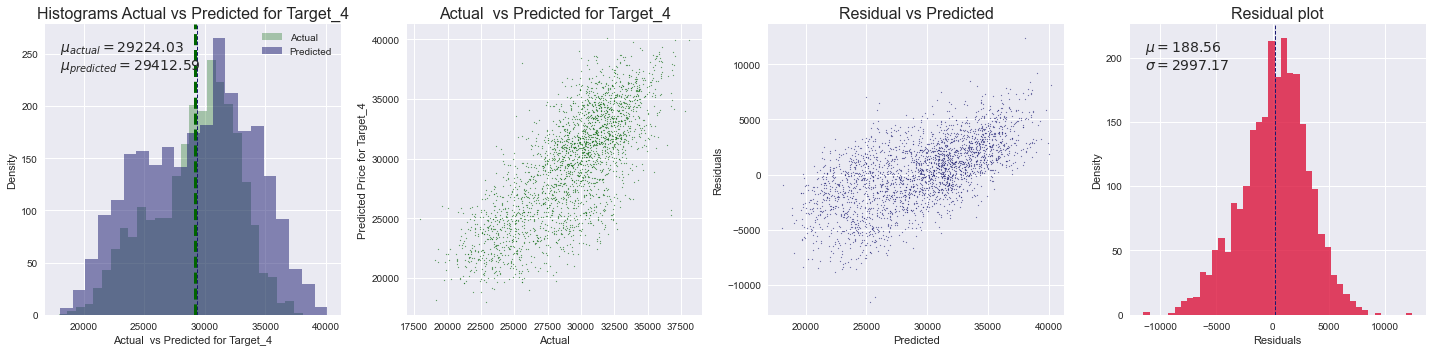

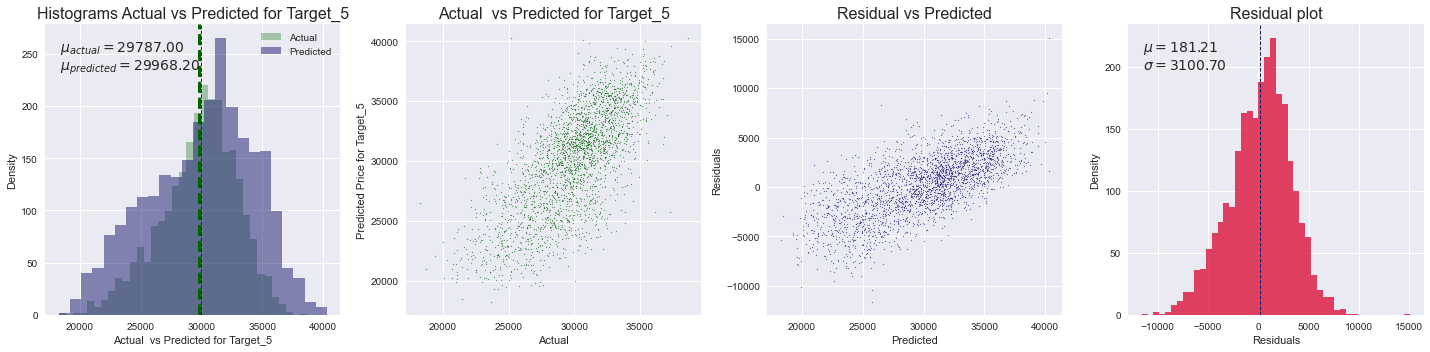

In [77]:
load_prediction_0 = ada_wrapped_svr_0.predict(load_atribute_test_0)
e_minus_o_l_0 = get_and_plot_data(load_prediction_0, load_target_test_0, start_index=1, stop_index=5)

In [78]:
print(get_ttest (load_prediction_0, load_target_test_0, idx=10))

p-value: 0.043555397279121985
we are rejecting null hypothesis


In [79]:
print(get_ztest (load_prediction_0, load_target_test_0, idx=10))

p-value: 0.043450636077322455
reject null hypothesis


In [ ]:
plot_actual_vs_prediction(load_prediction_0, load_target_test_0, variable_name = 'Load', start_inx = 2000, end_inx = 2005)
# beteen 0 and 2543 ----> count of observations in len(load_target_test_0)

In [104]:
svr = LinearSVR(C=10, max_iter = 1000, tol = 0.001, random_state=42,  loss='squared_epsilon_insensitive', dual=False)

@timeit
def ada_svr(estimator, att, target):
    ada_boost = AdaBoostRegressor(base_estimator = estimator, n_estimators = 10, learning_rate = 1)
    ada_wrapped = MultiOutputRegressor(estimator=ada_boost)
    ada_wrapped.fit(att, target)
    return ada_wrapped

ada_wrapped_svr_pca_0 = ada_svr(svr, PC_train_0, load_target_train_0)

Function took 313.6994 seconds


In [107]:
save_model(ada_wrapped_svr_pca_0, "#ada_load_wrapped_svr_gmm_pca_0.sav")

In [ ]:
ada_wrapped_svr_0=load_model("#ada_load_wrapped_svr_gmm_pca_0.sav")

In [105]:
_, _, _ = evaluation_report(ada_wrapped_svr_pca_0, PC_train_0, load_target_train_0)

Score Results:
Mean squared error: 7354314.90
Root mean squared error: 2693.04
Mean absolute error: 2113.29
Coefficient of determination: 0.5710
Predicted mean: 28551.076 (3564.575)


In [106]:
_, _, _ = evaluation_report(ada_wrapped_svr_pca_0, PC_test_0, load_target_test_0)

Score Results:
Mean squared error: 7598054.75
Root mean squared error: 2738.47
Mean absolute error: 2147.97
Coefficient of determination: 0.5631
Predicted mean: 28580.411 (3567.789)


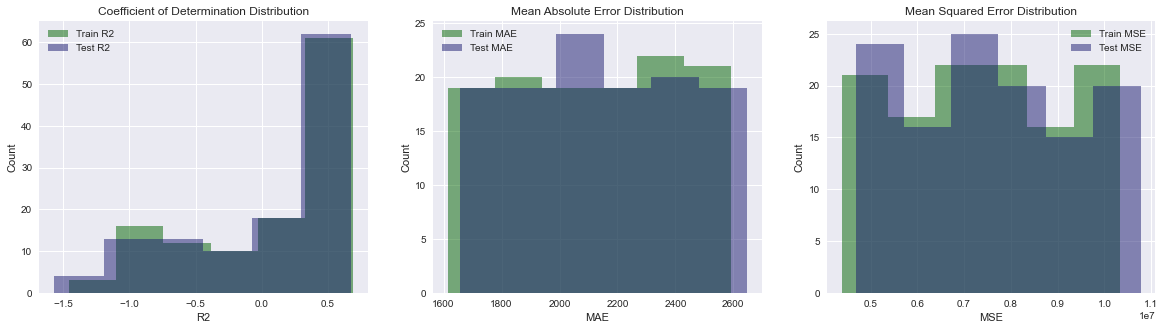

In [108]:
r2_train_0, r2_test_0, mae_train_0, mae_test_0, mse_train_0, mse_test_0 = generate_score_distributions(ada_wrapped_svr_pca_0, PC_train_0, load_target_train_0, PC_test_0, load_target_test_0)

In [109]:
pv_r2_ttest_0 = get_ttest_2samples(r2_train_0, r2_test_0)
pv_mae_ttest_0 = get_ttest_2samples(mae_train_0, mae_test_0)
pv_mse_ttest_0 = get_ttest_2samples(mse_train_0, mse_test_0)

p-value: 0.6848412088519378
fail to reject the null hypothesis
p-value: 0.3318807654261765
fail to reject the null hypothesis
p-value: 0.2715394502559486
fail to reject the null hypothesis


In [110]:
pv_r2_ztest_0 = get_ztest_2samples(r2_train_0, r2_test_0)
pv_mae_ztest_0 = get_ztest_2samples(mae_train_0, mae_test_0)
pv_mse_ztest_0 = get_ztest_2samples(mse_train_0, mse_test_0)

p-value: 0.6844760585469027
fail to reject the null hypothesis
p-value: 0.3308936221731853
fail to reject the null hypothesis
p-value: 0.2704262239104491
fail to reject the null hypothesis


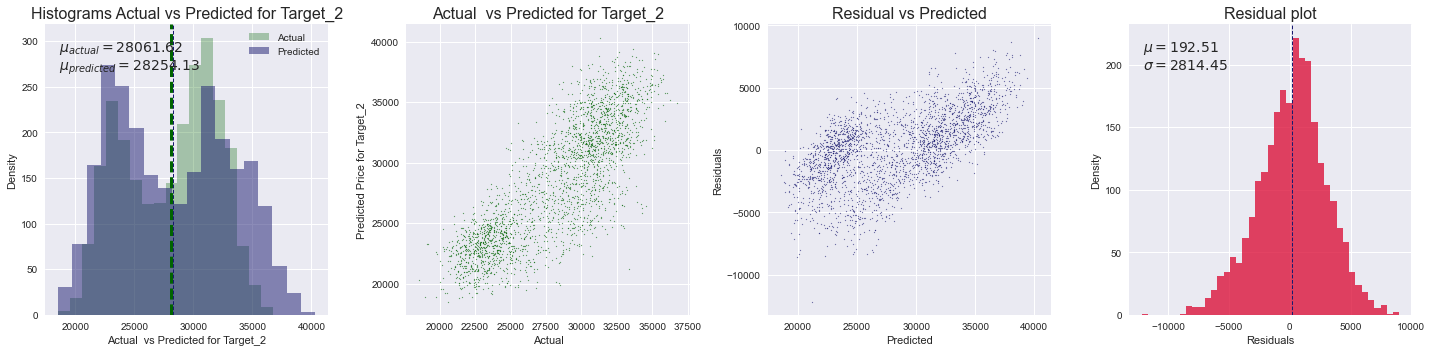

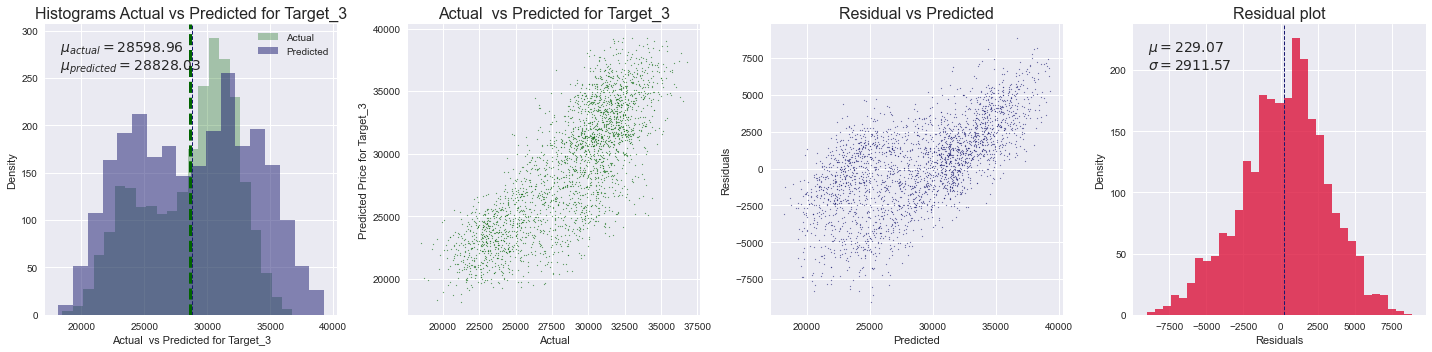

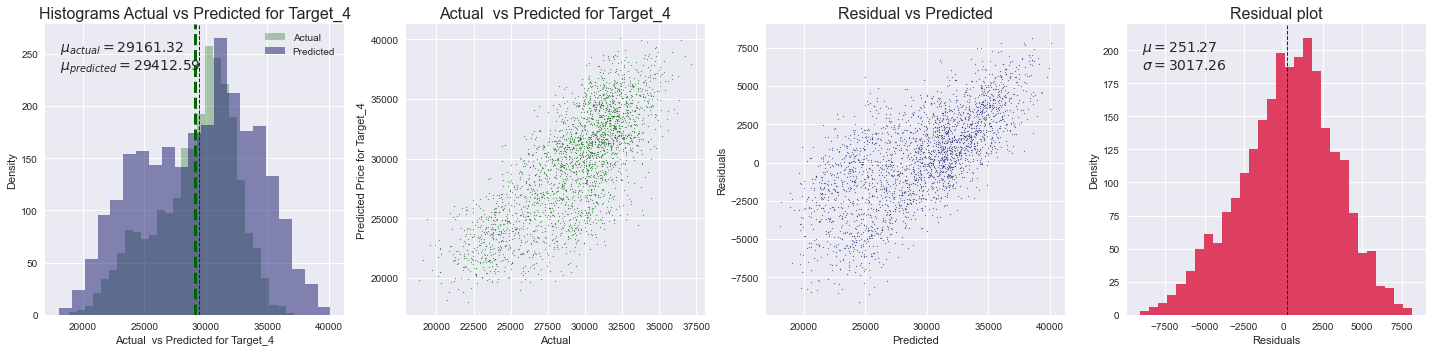

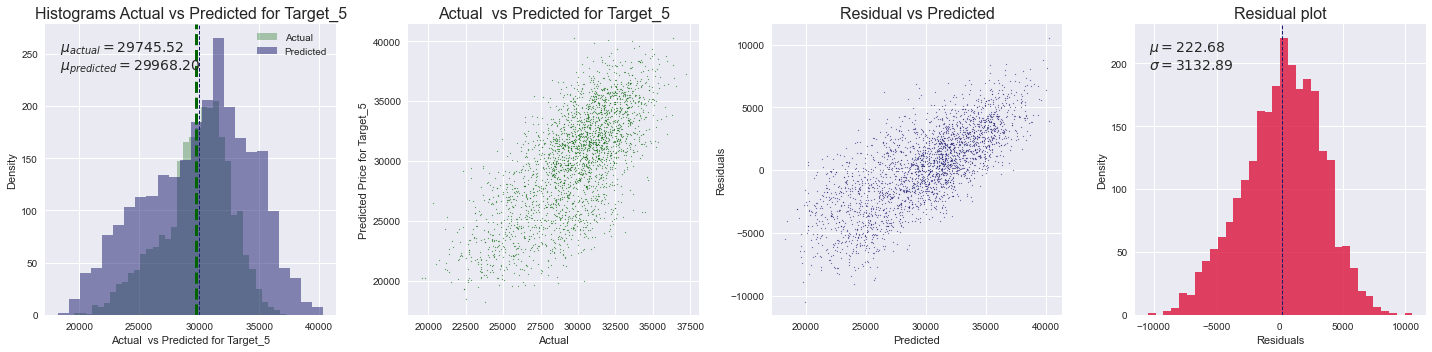

In [111]:
load_prediction_0 = ada_wrapped_svr_pca_0.predict(PC_test_0)
e_minus_o_l_0 = get_and_plot_data(load_prediction_0, load_target_test_0, start_index=1, stop_index=5)

In [112]:
print(get_ttest (load_prediction_0, load_target_test_0, idx=10))

p-value: 0.012337687008580374
we are rejecting null hypothesis


In [113]:
print(get_ztest (load_prediction_0, load_target_test_0, idx=10))

p-value: 0.01227549968943856
reject null hypothesis


In [114]:
svr_1 = LinearSVR(C=1, max_iter = 1000, tol = 0.001, random_state=42,  loss='squared_epsilon_insensitive', dual=False)

@timeit
def ada_svr(estimator, att, target):
    ada_boost = AdaBoostRegressor(base_estimator = estimator, n_estimators = 10, learning_rate = 1)
    ada_wrapped = MultiOutputRegressor(estimator=ada_boost)
    ada_wrapped.fit(att, target)
    return ada_wrapped

ada_wrapped_svr_1 = ada_svr(svr_1, load_atribute_train_1, load_target_train_1)

Function took 4923.7795 seconds


In [115]:
save_model(ada_wrapped_svr_1, "#ada_load_wrapped_svr_gmm_1.sav")

In [127]:
ada_wrapped_svr_1=load_model("#ada_load_wrapped_svr_gmm_1.sav")

In [129]:
_, _, _ = evaluation_report(ada_wrapped_svr_1, load_atribute_train_1, load_target_train_1)

Score Results:
Mean squared error: 6889917.99
Root mean squared error: 2603.58
Mean absolute error: 2078.82
Coefficient of determination: 0.6019
Predicted mean: 28504.589 (3669.523)


In [130]:
_, _, _ = evaluation_report(ada_wrapped_svr_1, load_atribute_test_1, load_target_test_1)

Score Results:
Mean squared error: 7696902.52
Root mean squared error: 2753.11
Mean absolute error: 2165.15
Coefficient of determination: 0.5543
Predicted mean: 28493.248 (3684.417)


In [116]:
@timeit
def xgb_boosting (att, target):
    xgb_test = xgb.XGBRegressor(gamma=0.2,
                                n_estimators=250,
                                max_depth=4,
                                base_score=0.7,
                                colsample_bytree=0.73,
                                learning_rate=0.2,
                                subsample = 0.9)
    mo_xgb = MultiOutputRegressor(xgb_test)
    mo_xgb_fitted = mo_xgb.fit(att, target)  
    
    return mo_xgb_fitted

load_xgb_gmm_0 = xgb_boosting(PC_train_0, load_target_train_0)

Function took 1638.6993 seconds


In [117]:
save_model(load_xgb_gmm_0, "#load_xgb_gmm_0.sav")

In [124]:
load_xgb_gmm_0=load_model("#load_xgb_gmm_0.sav")

In [125]:
_, _, _ = evaluation_report(load_xgb_gmm_0, PC_train_0, load_target_train_0)

Score Results:
Mean squared error: 1238132.98
Root mean squared error: 1109.73
Mean absolute error: 838.15
Coefficient of determination: 0.9280
Predicted mean: 28682.047 (4179.538)


In [126]:
_, _, _ = evaluation_report(load_xgb_gmm_0, PC_test_0, load_target_test_0)

Score Results:
Mean squared error: 2929731.55
Root mean squared error: 1708.94
Mean absolute error: 1278.79
Coefficient of determination: 0.8322
Predicted mean: 28697.311 (4009.404)


In [118]:
@timeit
def xgb_boosting (att, target):
    xgb_test = xgb.XGBRegressor(gamma=0.2,
                                n_estimators=250,
                                max_depth=4,
                                base_score=0.7,
                                colsample_bytree=0.73,
                                learning_rate=0.2,
                                subsample = 0.9)
    mo_xgb = MultiOutputRegressor(xgb_test)
    mo_xgb_fitted = mo_xgb.fit(att, target)  
    
    return mo_xgb_fitted

load_xgb_gmm_1 = xgb_boosting(PC_train_1, load_target_train_1)

Function took 1645.4825 seconds


In [119]:
save_model(load_xgb_gmm_1, "#load_xgb_gmm_1.sav")

In [ ]:
load_xgb_gmm_1=load_model("#load_xgb_gmm_1.sav")

In [122]:
_, _, _ = evaluation_report(load_xgb_gmm_1, PC_train_1, load_target_train_1)

Score Results:
Mean squared error: 1271190.10
Root mean squared error: 1124.24
Mean absolute error: 847.22
Coefficient of determination: 0.9267
Predicted mean: 28660.719 (4173.635)


In [123]:
_, _, _ = evaluation_report(load_xgb_gmm_1, PC_test_1, load_target_test_1)

Score Results:
Mean squared error: 2910872.15
Root mean squared error: 1703.25
Mean absolute error: 1270.60
Coefficient of determination: 0.8319
Predicted mean: 28665.105 (4005.717)


In [30]:
# min_max_normalize
# load_actual = pd.DataFrame(min_max_normalize(df_data_load['total load actual']))

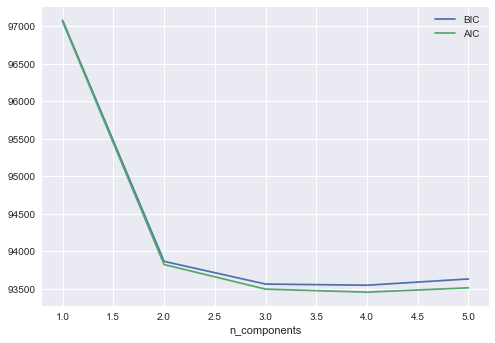

In [74]:
n_components = np.arange(1, 6)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(load_actual)
          for n in n_components]

plt.plot(n_components, [m.bic(load_actual) for m in models], label='BIC')
plt.plot(n_components, [m.aic(load_actual) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [78]:
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(load_actual)
labels = gmm.predict(load_actual)
# https://vitalflux.com/gaussian-mixture-models-what-are-they-when-to-use/
# https://www.scribbr.com/statistics/akaike-information-criterion/
# https://bg.eferrit.com/%D0%B2%D1%8A%D0%B2%D0%B5%D0%B4%D0%B5%D0%BD%D0%B8%D0%B5-%D0%B2-%D0%B8%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B8%D1%8F-%D0%BA%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9/

In [79]:
gmm.means_, gmm.covariances_, 

(array([[-0.89309797],
        [ 0.73425126]]),
 array([[[0.2830101 ]],
 
        [[0.39453116]]]))

In [80]:
gmm.weights_, gmm.lower_bound_

(array([0.45119464, 0.54880536]), -1.3718287162761942)

In [25]:
df_data_load['cluster']=labels
df_data_load_distribution_0 = df_data_load[df_data_load["cluster"]==0]
df_data_load_distribution_1 = df_data_load[df_data_load["cluster"]==1]

In [26]:
def get_data(df_data, col_name):
    target_cols = [col for col in df_data.columns if 'Target' in col]
    target = df_data[target_cols]       
    attribute = df_data.drop(["time", "cluster", col_name], axis = 1)
    attribute = attribute.drop(target_cols, axis = 1)
    return target, attribute, df_data

In [27]:
target_0, attribute_0, df_data_0 = get_data(df_data_load_distribution_0, "total load actual")

In [28]:
target_1, attribute_1, df_data_1 = get_data(df_data_load_distribution_1, "total load actual")

In [29]:
target_0.shape, attribute_0.shape,

((15325, 120), (15325, 798))

In [30]:
target_1.shape, attribute_1.shape,

((18877, 120), (18877, 798))

In [33]:
load_atribute_train_0, load_atribute_test_0, load_target_train_0, load_target_test_0, load_attribute_col_names_0 = scaled_data(target_0, attribute_0, TEST_SIZE, scaler_z_score)
load_atribute_train_1, load_atribute_test_1, load_target_train_1, load_target_test_1, load_attribute_col_names_1 = scaled_data(target_1, attribute_1, TEST_SIZE, scaler_z_score)

In [34]:
load_target_test_1

Target_1  Target_2  Target_3  Target_4  Target_5  Target_6  Target_7  \
591     34110.0   33481.0   33139.0   33159.0   33441.0   36177.0   37158.0   
30814   29837.0   28424.0   29365.0   27495.0   25997.0   25480.0   25043.0   
32682   29358.0   30882.0   32827.0   31672.0   28601.0   26194.0   24638.0   
14415   30739.0   30540.0   30628.0   30282.0   30194.0   31710.0   31584.0   
17401   29522.0   27313.0   26041.0   25476.0   25271.0   25958.0   28740.0   
...         ...       ...       ...       ...       ...       ...       ...   
19617   31963.0   32371.0   32424.0   32630.0   32378.0   31132.0   30154.0   
15743   31730.0   28703.0   26532.0   24797.0   23627.0   23250.0   23162.0   
27310   35065.0   32328.0   29528.0   27513.0   25726.0   24749.0   24393.0   
11529   30236.0   30836.0   30926.0   31293.0   31352.0   30500.0   29901.0   
16196   25363.0   26019.0   27229.0   28303.0   26732.0   29806.0   27786.0   

       Target_8  Target_9  Target_10  ...  Target_111  Target_112  Target_113  \
591     36245.0   33674.0    30554.0  ...     24879.0     25506.0     28104.0   
30814   25123.0   26574.0    28273.0  ...     28032.0     28116.0     27924.0   
32682   23402.0   22613.0    22303.0  ...     28781.0     31412.0     32914.0   
14415   28614.0   26536.0    25334.0  ...     23821.0     25918.0     29430.0   
17401   33642.0   36773.0    37957.0  ...     34362.0     33739.0     33432.0   
...         ...       ...        ...  ...         ...         ...         ...   
19617   29621.0   29341.0    28959.0  ...     27868.0     25773.0     23843.0   
15743   23724.0   26141.0    30324.0  ...     34582.0     34315.0     32964.0   
27310   24440.0   24925.0    27541.0  ...     35525.0     35444.0     35394.0   
11529   29916.0   29882.0    29528.0  ...     26539.0     24949.0     23414.0   
16196   26361.0   25738.0    25444.0  ...     27640.0     29042.0     29141.0   

       Target_114  Target_115  Target_116  Target_117  Target_118  Target_119  \
591       32929.0     35765.0     37147.0     37681.0     37765.0     37489.0   
30814     26752.0     25914.0     26218.0     28437.0     29204.0     29850.0   
32682     33661.0     33975.0     34176.0     33961.0     33048.0     32558.0   
14415     31296.0     31597.5     31899.0     32380.0     32770.0     32766.0   
17401     33443.0     34729.0     36706.0     37047.0     36175.0     33521.0   
...           ...         ...         ...         ...         ...         ...   
19617     22392.0     21633.0     21248.0     21220.0     21670.0     21886.0   
15743     32663.0     32502.0     33378.0     35167.0     35550.0     35618.0   
27310     34266.0     33388.0     33167.0     33058.0     33193.0     34932.0   
11529     22626.0     22285.0     22228.0     22612.0     24044.0     26354.0   
16196     28860.0     28902.0     28364.0     27259.0     26623.0     26808.0   

       Target_120  
591       37385.0  
30814     29806.0  
32682     32271.0  
14415     31747.0  
17401     30238.0  
...           ...  
19617     22702.0  
15743     34357.0  
27310     36596.0  
11529     28576.0  
16196     28707.0  

[2832 rows x 120 columns]

In [35]:
load_linear_regression_0 = LinearRegression().fit(load_atribute_train_0, load_target_train_0)
load_linear_regression_1 = LinearRegression().fit(load_atribute_train_1, load_target_train_1)

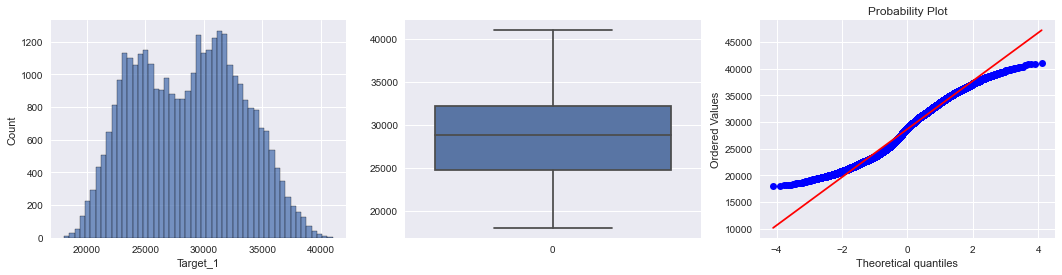

In [36]:
for i in range(1, 2):
    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
    sns.histplot(data = load_target[f"Target_{i}"], ax=ax[0])
    sns.boxplot(data = load_target[f"Target_{i}"], ax=ax[1])
    stats.probplot(load_target[f"Target_{i}"], plot=ax[2])
    plt.show()

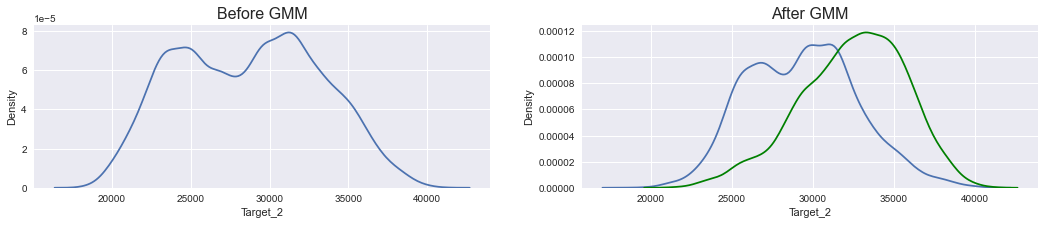

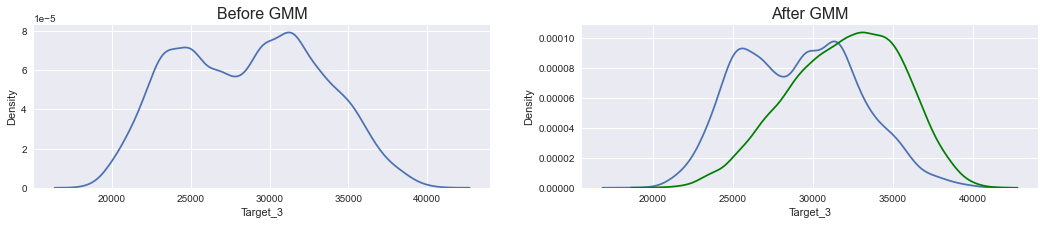

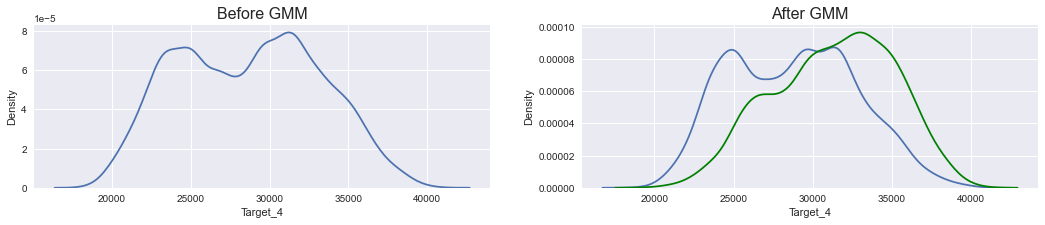

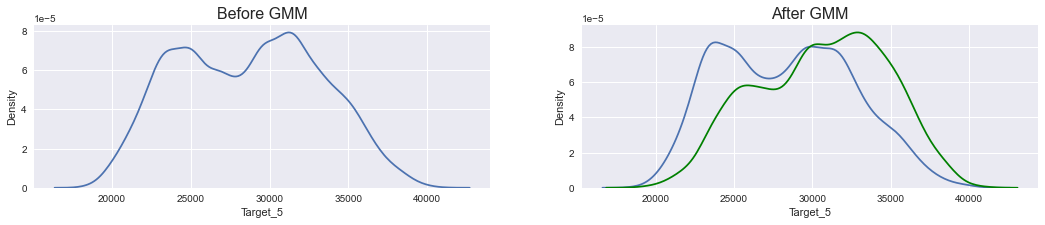

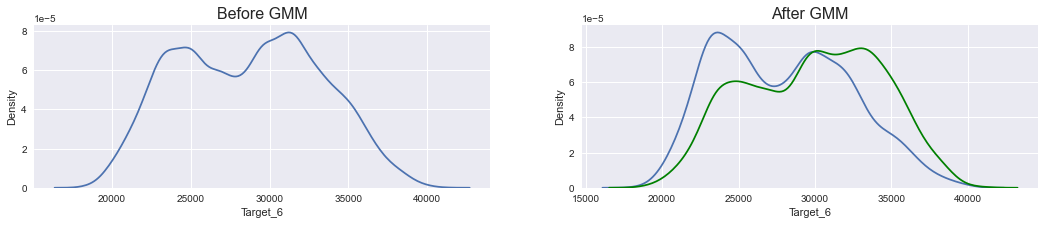

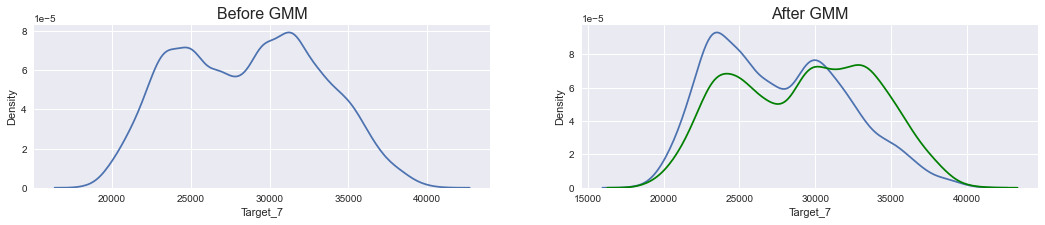

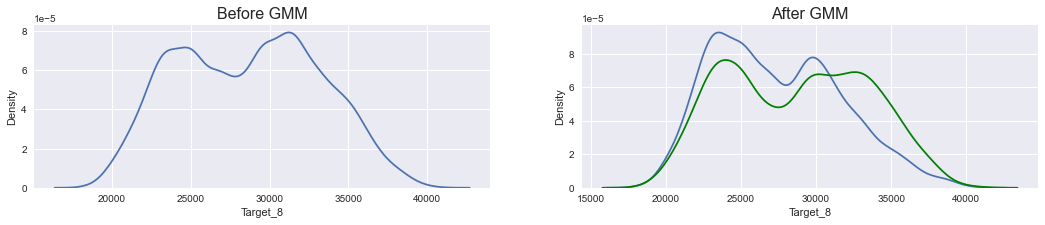

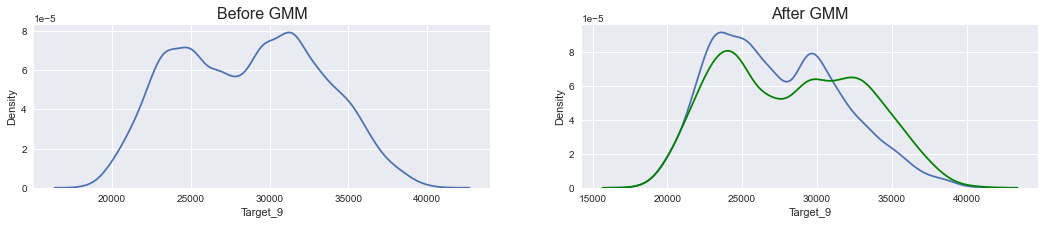

In [111]:
 for i in range(2, 10):   #range(5, 6)
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 3))
    sns.kdeplot(data=load_target[f"Target_{i}"], ax=ax[0])
    ax[0].set_title('Before GMM', fontsize=16)
    sns.kdeplot(data=load_target_train_0[f"Target_{i}"], label='Component 1', ax=ax[1])
    sns.kdeplot(data=load_target_train_1[f"Target_{i}"], label='Component 2', color = 'g', ax=ax[1])
    ax[1].set_title('After GMM', fontsize=16)
    plt.show()

# https://www.kaggle.com/code/iamleonie/handling-multimodal-distributions-fe-techniques

In [38]:
len(load_atribute_test_0), len(load_atribute_train_0), len(load_atribute_test_1), len(load_atribute_train_1)

(2299, 13026, 2832, 16045)

In [39]:
lp_0 = load_linear_regression_0.predict(load_atribute_test_0)
lp_1 = load_linear_regression_1.predict(load_atribute_test_1)

In [40]:
_, _, _ = evaluation_report(load_linear_regression_0, load_atribute_train_0, load_target_train_0)

Score Results:
Mean squared error: 5915758.39
Root mean squared error: 2412.62
Mean absolute error: 1820.79
Coefficient of determination: 0.6731
Predicted mean: 28634.986 (3777.764)


In [41]:
_, _, _ = evaluation_report(load_linear_regression_0, load_atribute_test_0, load_target_test_0)

Score Results:
Mean squared error: 6982996.44
Root mean squared error: 2621.62
Mean absolute error: 1975.77
Coefficient of determination: 0.6138
Predicted mean: 28639.162 (3799.729)


In [42]:
_, _, _ = evaluation_report(load_linear_regression_1, load_atribute_train_1, load_target_train_1)

Score Results:
Mean squared error: 6566446.55
Root mean squared error: 2551.36
Mean absolute error: 1933.53
Coefficient of determination: 0.6581
Predicted mean: 28713.882 (3820.952)


In [43]:
_, _, _ = evaluation_report(load_linear_regression_1, load_atribute_test_1, load_target_test_1)

Score Results:
Mean squared error: 431052616295459450772636303360.00
Root mean squared error: 538718606788622.06
Mean absolute error: 10123142527103.07
Coefficient of determination: -22047280853318704824320.0000
Predicted mean: -3055861068581.969 (656538862527095.625)


In [112]:
# mean_absolute_error(load_target_test_1 , lp_1 , multioutput = 'raw_values')

In [111]:
#  r2_score ( load_target_test_0 , lp_0 , multioutput = 'raw_values')

In [120]:
#  r2_score ( load_target_test_1 , lp_1 , multioutput = 'raw_values')

In [44]:
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return r_value**2


In [45]:
ls_1_test=[]
for i in range(0, 119):
    l = rsquared(load_target_test_1[f'Target_{i+1}'], pd.DataFrame(lp_1).iloc[:, i])
    ls_1_test.append(l)

In [46]:
ls_0_test=[]
for i in range(0, 119):
    l = rsquared(load_target_test_0[f'Target_{i+1}'], pd.DataFrame(lp_0).iloc[:, i])
    ls_0_test.append(l)

In [47]:
np.mean(ls_1_test), np.mean(ls_0_test)

(0.0002563693084544922, 0.6155346471403919)

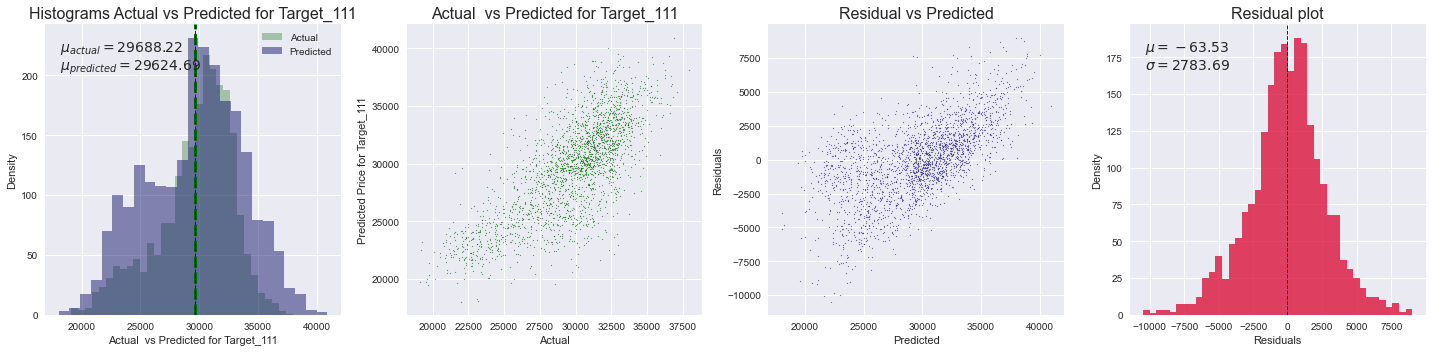

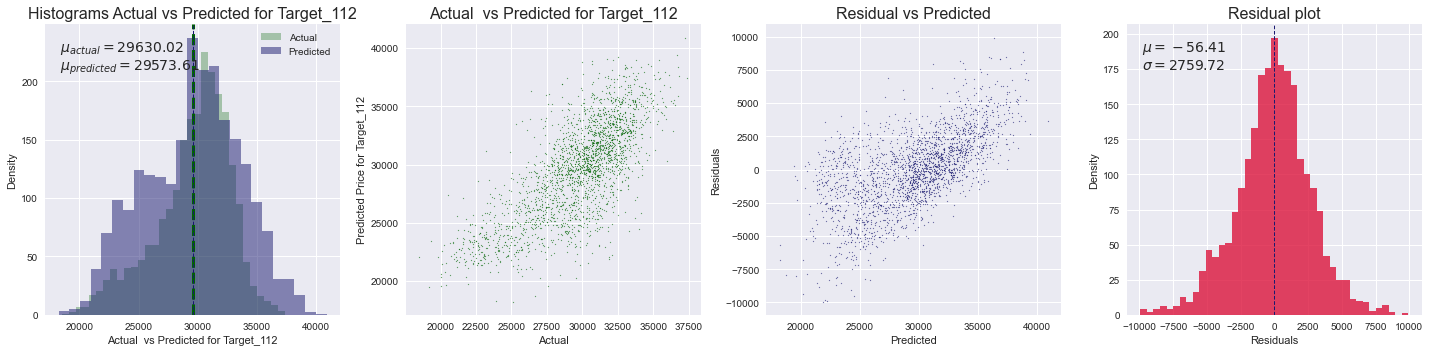

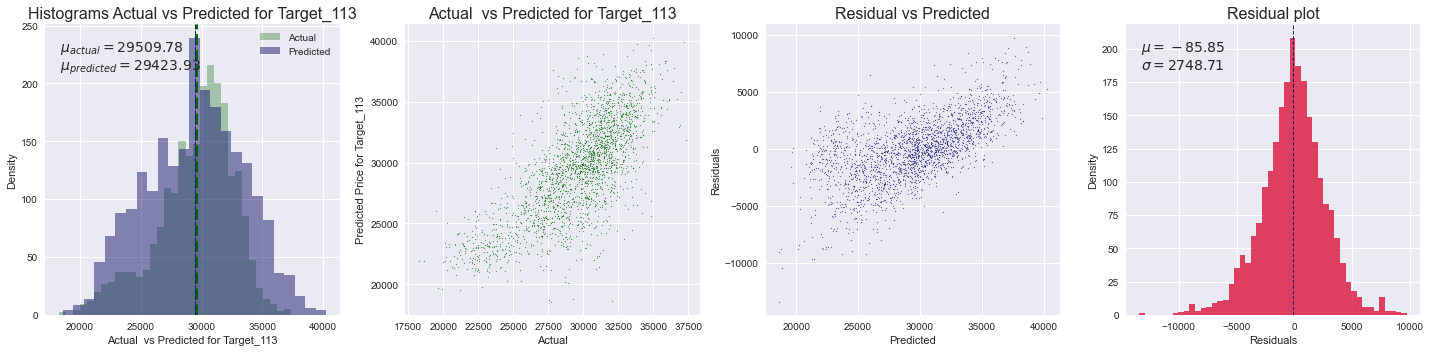

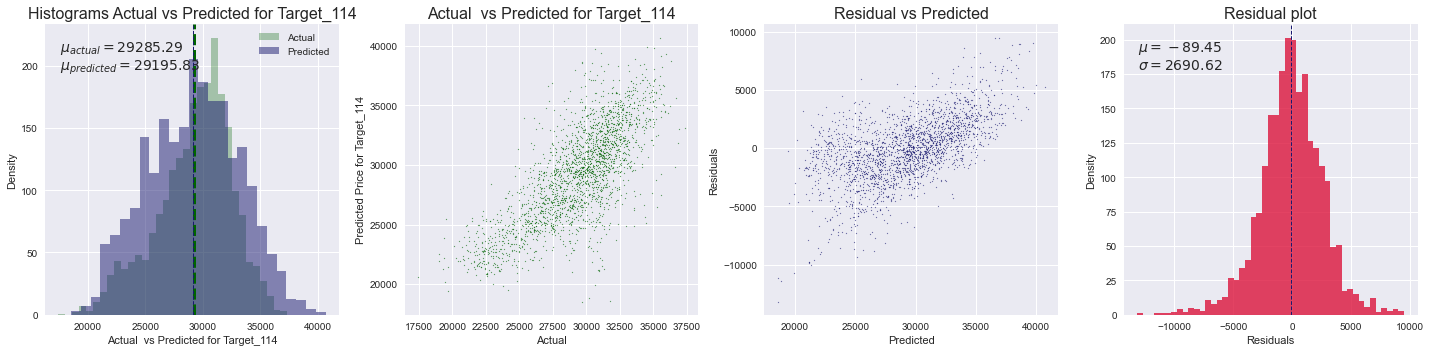

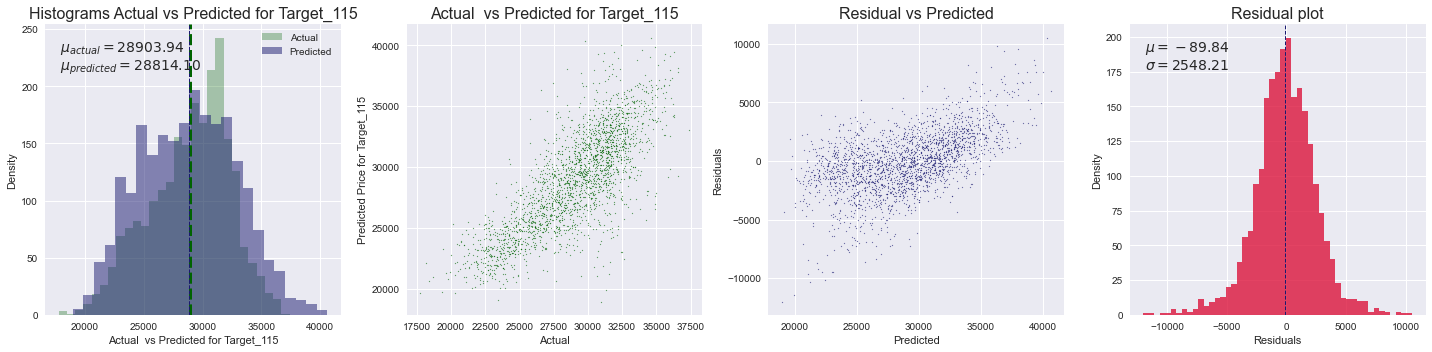

In [48]:
load_prediction_0 = load_linear_regression_0.predict(load_atribute_test_0)
e_minus_o_l_0 = get_and_plot_data(load_prediction_0, load_target_test_0, start_index=110, stop_index=115)

In [49]:
load_prediction_1 = load_linear_regression_1.predict(load_atribute_test_1)

In [49]:
base = pd.DataFrame()
base["actual"] = load_target_test_1['Target_11']
base["predictions"] = [load_prediction_1[i][10] for i in range(0, len(load_prediction_1))]

In [50]:
base['diff'] = base['actual']-base['predictions']

In [51]:
base['diff'].min()

-2.632601024378249e+16

In [52]:
base[(base['predictions'] == base["predictions"].max())]


actual   predictions          diff
29677  29578.0  2.632601e+16 -2.632601e+16

In [53]:

base[(base['diff']<-13000) ]

actual   predictions          diff
29677  29578.0  2.632601e+16 -2.632601e+16

In [51]:
# e_minus_o_l_1 = get_and_plot_data(load_prediction_1, load_target_test_1, start_index=16, stop_index=17)

In [23]:
# target_0, attribute_0, df_data_0 = get_data(df_data_load_distribution_0, "total load actual")

In [24]:
# target_1, attribute_1, df_data_1 = get_data(df_data_load_distribution_1, "total load actual")

In [268]:
# Ще добавим работен час и работен ден към данните. Това се надявам да обясни модалността. После всичко от начало.

In [112]:
load_target, load_attribute, df_data_load = read_data("total load actual",  r"data\df_data_load_ts720_120_24.csv")
df_data_load['time'] = pd.to_datetime(df_data_load['time'], utc=True, infer_datetime_format=True)
df_data_load['hour'] = df_data_load['time'].dt.hour
df_data_load['month'] = df_data_load['time'].dt.month
df_data_load['business hour'] = 0

for i in range(len(df_data_load)):
    position = df_data_load.index[i]
    hour = df_data_load['hour'][i]
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        df_data_load.loc[position, 'business hour'] = 1
    else:
        pass

In [53]:
df_data_load.to_csv('data/df_data_load_ts720_120_24_work_hours.csv', index=False)

In [113]:
load_target, load_attribute, df_data_load = read_data("total load actual",  r"data\df_data_load_ts720_120_24_work_hours.csv")

In [114]:
la = pd.DataFrame(z_score_normalize(df_data_load['total load actual']))

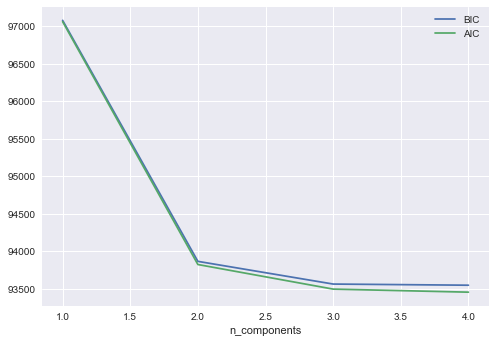

In [115]:
n_components = np.arange(1, 5)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(la)
          for n in n_components]

plt.plot(n_components, [m.bic(la) for m in models], label='BIC')
plt.plot(n_components, [m.aic(la) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [116]:
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(la)
labels = gmm.predict(la)

In [117]:
df_data_load['cluster']=labels
df_data_load_distribution_0 = df_data_load[df_data_load["cluster"]==0]
df_data_load_distribution_1 = df_data_load[df_data_load["cluster"]==1]

In [118]:
def get_data(df_data, col_name):
    target_cols = [col for col in df_data.columns if 'Target' in col]
    target = df_data[target_cols]       
    attribute = df_data.drop(["time", "cluster", col_name], axis = 1)
    attribute = attribute.drop(target_cols, axis = 1)
    return target, attribute, df_data

In [119]:
target_0, attribute_0, df_data_0 = get_data(df_data_load_distribution_0, "total load actual")

In [120]:
target_1, attribute_1, df_data_1 = get_data(df_data_load_distribution_1, "total load actual")

In [121]:
target_0.shape, attribute_0.shape,

((15325, 120), (15325, 801))

In [122]:
target_1.shape, attribute_1.shape,

((18877, 120), (18877, 801))

In [123]:
load_atribute_train_0, load_atribute_test_0, load_target_train_0, load_target_test_0, load_attribute_col_names_0 = scaled_data(target_0, attribute_0, TEST_SIZE, scaler_z_score)
load_atribute_train_1, load_atribute_test_1, load_target_train_1, load_target_test_1, load_attribute_col_names_1 = scaled_data(target_1, attribute_1, TEST_SIZE, scaler_z_score)

In [124]:
load_linear_regression_0 = LinearRegression().fit(load_atribute_train_0, load_target_train_0)
load_linear_regression_1 = LinearRegression().fit(load_atribute_train_1, load_target_train_1)

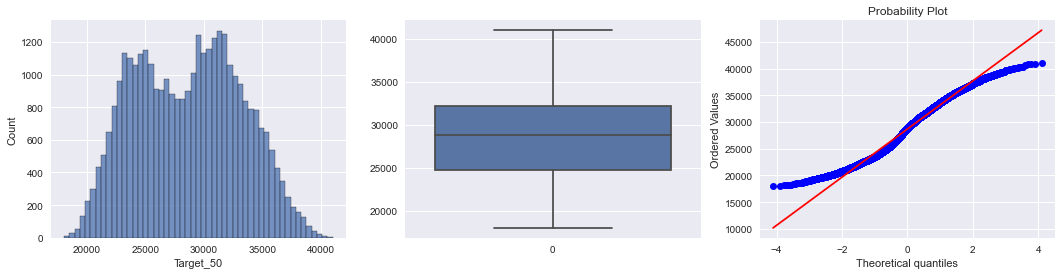

In [66]:
#display(train_df.target.describe())
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
# sns.distplot(load_target["Target_50"], ax=ax[0])
sns.histplot(data = load_target["Target_50"], ax=ax[0])
sns.boxplot(data = load_target["Target_50"], ax=ax[1])
stats.probplot(load_target['Target_50'], plot=ax[2])
plt.show()

Цел

    Изглежда като наслагване на две различни разпределения - когато разпределението на данните има два пика, това се нарича бимодално разпределение .
    Има точно една точка от данни с целева стойност 0 - това много прилича на отклонение . Вероятно трябва да го изпуснем, тъй като това е само една точка от данни.
    Данните не изглеждат изкривени и следователно не е задължително да се трансформират (ако се използват модели, които не са базирани на дърво - за модели, базирани на дърво, това така или иначе няма да има значение).


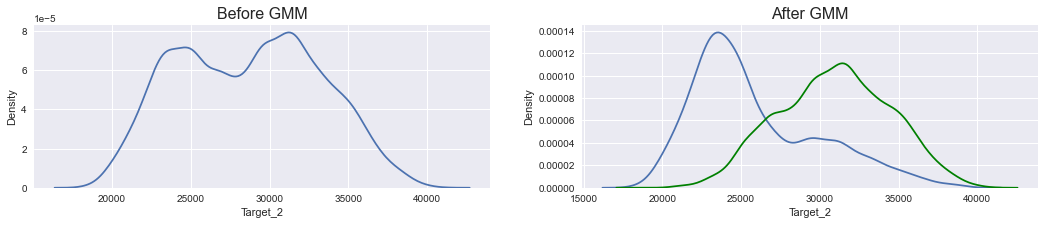

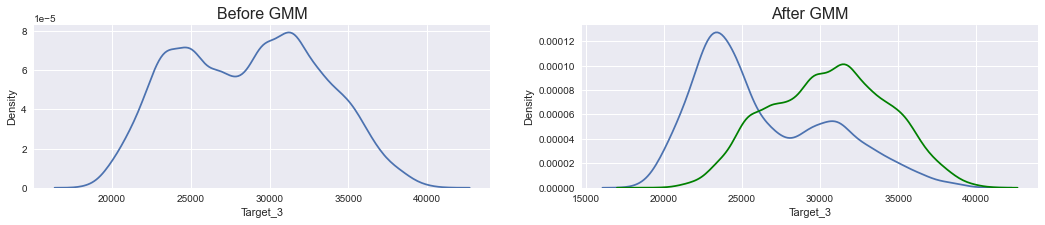

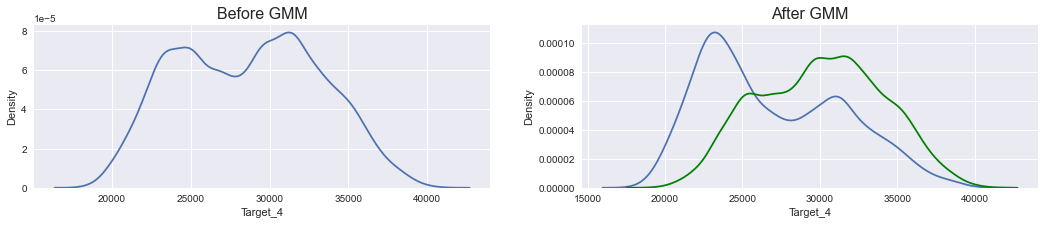

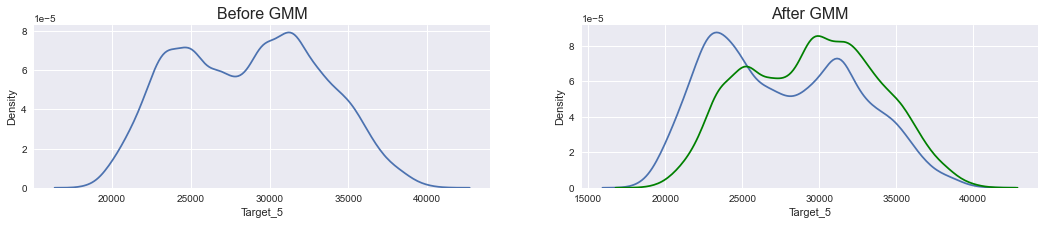

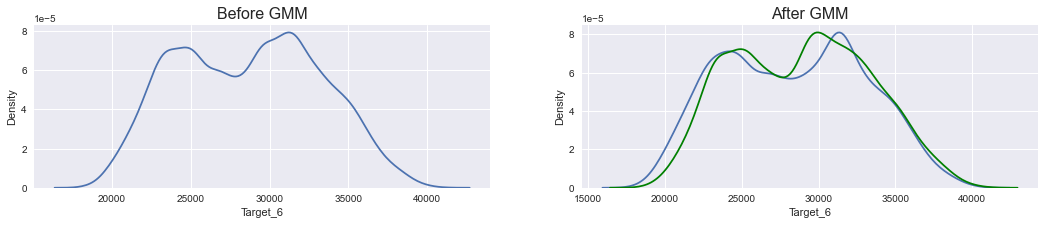

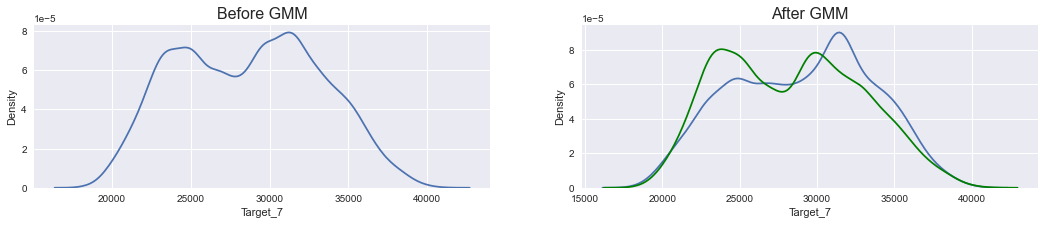

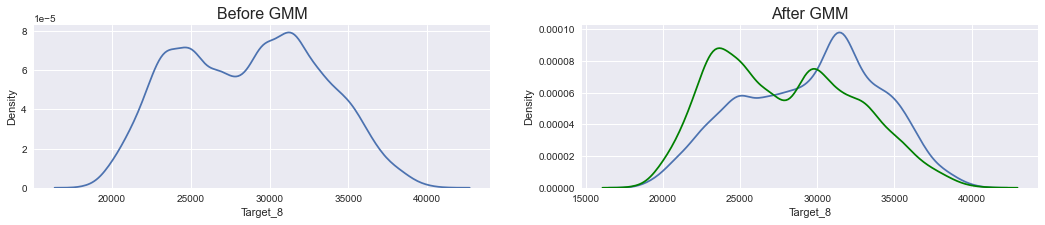

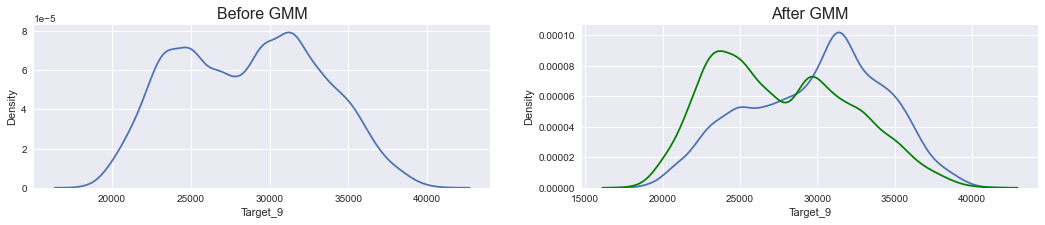

In [125]:
for i in range(2, 10):   #range(5, 6)
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 3))
    sns.kdeplot(data=load_target[f"Target_{i}"], ax=ax[0])
    ax[0].set_title('Before GMM', fontsize=16)
    sns.kdeplot(data=load_target_train_0[f"Target_{i}"], label='Component 1', ax=ax[1])
    sns.kdeplot(data=load_target_train_1[f"Target_{i}"], label='Component 2', color = 'g', ax=ax[1])
    ax[1].set_title('After GMM', fontsize=16)
    plt.show()

# https://www.kaggle.com/code/iamleonie/handling-multimodal-distributions-fe-techniques

In [126]:
len(load_atribute_test_0), len(load_atribute_train_0), len(load_atribute_test_1), len(load_atribute_train_1)

(2299, 13026, 2832, 16045)

In [46]:
# mean_absolute_error(load_target_test_1 , lp_1 , multioutput = 'raw_values')

In [47]:
#  r2_score ( load_target_test_0 , lp_0 , multioutput = 'raw_values')

In [48]:
#  r2_score ( load_target_test_1 , lp_1 , multioutput = 'raw_values')

In [127]:
_, _, _ = evaluation_report(load_linear_regression_0, load_atribute_train_0, load_target_train_0)

Score Results:
Mean squared error: 5871985.32
Root mean squared error: 2403.75
Mean absolute error: 1813.31
Coefficient of determination: 0.6755
Predicted mean: 28634.986 (3783.237)


In [128]:
_, _, _ = evaluation_report(load_linear_regression_0, load_atribute_test_0, load_target_test_0)

Score Results:
Mean squared error: 6941298.89
Root mean squared error: 2613.93
Mean absolute error: 1969.47
Coefficient of determination: 0.6160
Predicted mean: 28641.518 (3805.436)


In [129]:
_, _, _ = evaluation_report(load_linear_regression_1, load_atribute_train_1, load_target_train_1)

Score Results:
Mean squared error: 6485071.34
Root mean squared error: 2535.76
Mean absolute error: 1919.26
Coefficient of determination: 0.6622
Predicted mean: 28713.822 (3831.574)


In [130]:
_, _, _ = evaluation_report(load_linear_regression_1, load_atribute_test_1, load_target_test_1)

Score Results:
Mean squared error: 261930522549508772508662235136.00
Root mean squared error: 419223788110554.25
Mean absolute error: 7877697381426.73
Coefficient of determination: -13367276629468215508992.0000
Predicted mean: -1317720685993.634 (511789787082152.812)


In [91]:
gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(la)
labels = gmm.predict(la)

In [92]:
df_data_load['cluster']=labels
df_data_load_distribution_0 = df_data_load[df_data_load["cluster"]==0]
df_data_load_distribution_1 = df_data_load[df_data_load["cluster"]==1]
df_data_load_distribution_2 = df_data_load[df_data_load["cluster"]==2]

In [93]:
target_0, attribute_0, df_data_0 = get_data(df_data_load_distribution_0, "total load actual")
target_1, attribute_1, df_data_1 = get_data(df_data_load_distribution_1, "total load actual")
target_2, attribute_2, df_data_2 = get_data(df_data_load_distribution_2, "total load actual")

In [94]:
load_atribute_train_0, load_atribute_test_0, load_target_train_0, load_target_test_0, load_attribute_col_names_0 = scaled_data(target_0, attribute_0, TEST_SIZE, scaler_min_max)
load_atribute_train_1, load_atribute_test_1, load_target_train_1, load_target_test_1, load_attribute_col_names_1 = scaled_data(target_1, attribute_1, TEST_SIZE, scaler_min_max)
load_atribute_train_2, load_atribute_test_2, load_target_train_2, load_target_test_2, load_attribute_col_names_2 = scaled_data(target_2, attribute_2, TEST_SIZE, scaler_z_score)

In [96]:
len(load_atribute_train_1), len(load_target_train_1)

(7631, 7631)

In [89]:
len(load_atribute_train_0), len(load_target_train_0)

(10302, 10302)

In [95]:
len(load_atribute_train_2), len(load_target_train_2)

(11138, 11138)

In [97]:
load_linear_regression_0 = LinearRegression().fit(load_atribute_train_0, load_target_train_0)
load_linear_regression_1 = LinearRegression().fit(load_atribute_train_1, load_target_train_1)
load_linear_regression_2 = LinearRegression().fit(load_atribute_train_2, load_target_train_2)

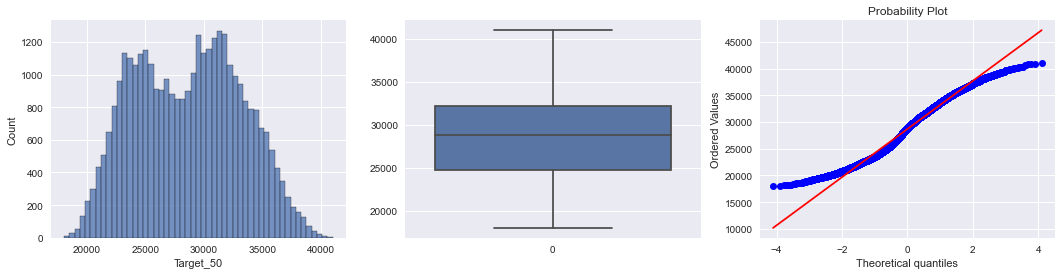

In [98]:
#display(train_df.target.describe())
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
# sns.distplot(load_target["Target_50"], ax=ax[0])
sns.histplot(data = load_target["Target_50"], ax=ax[0])
sns.boxplot(data = load_target["Target_50"], ax=ax[1])
stats.probplot(load_target['Target_50'], plot=ax[2])
plt.show()

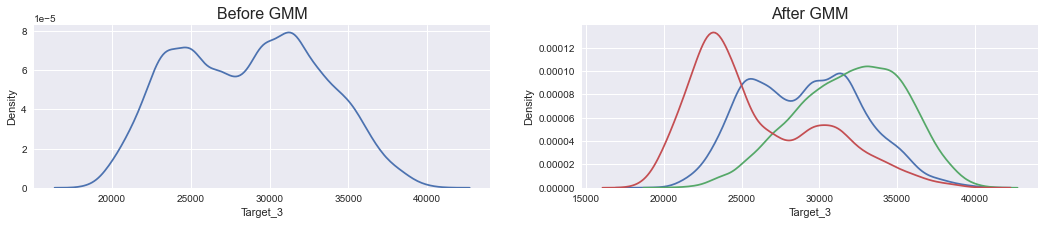

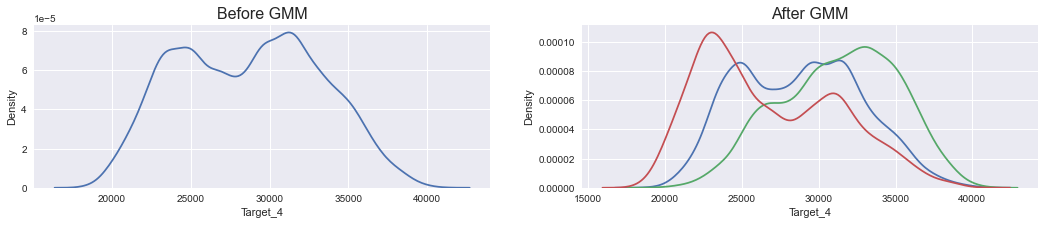

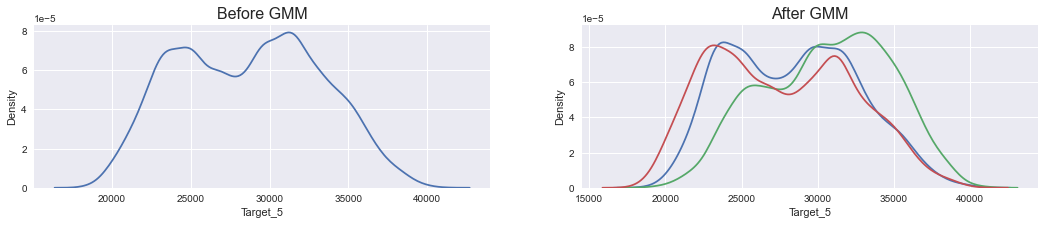

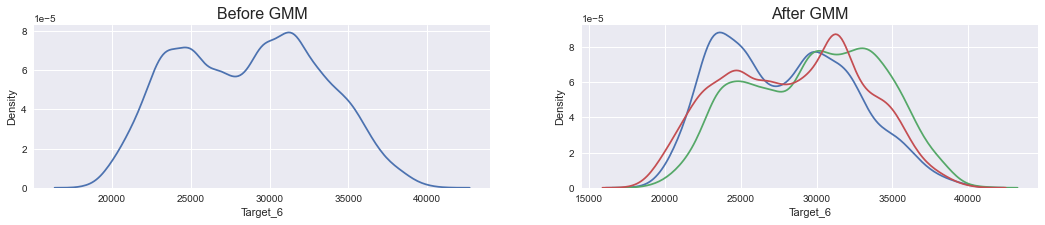

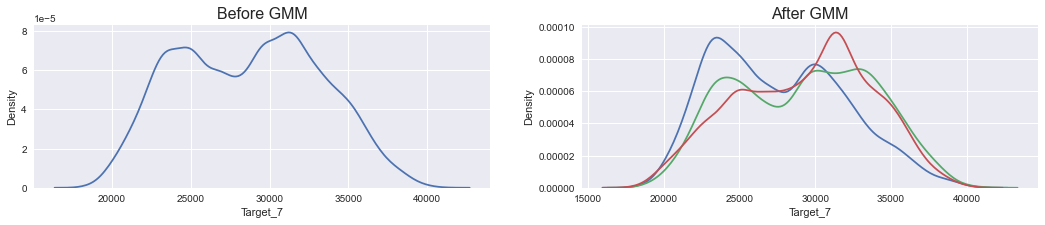

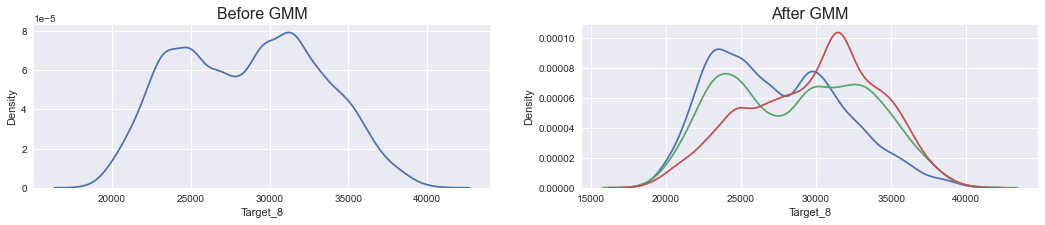

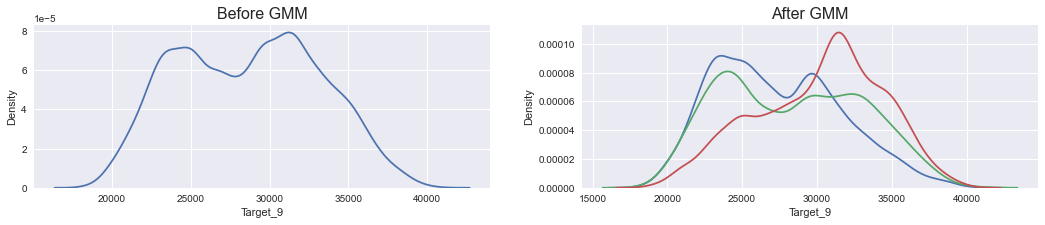

In [110]:
 for i in range(3, 10):   #range(5, 6)
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 3))
    sns.kdeplot(data=load_target[f"Target_{i}"], ax=ax[0])
    ax[0].set_title('Before GMM', fontsize=16)
    sns.kdeplot(data=load_target_train_0[f"Target_{i}"], label='Component 1', ax=ax[1])
    sns.kdeplot(data=load_target_train_1[f"Target_{i}"], label='Component 2', ax=ax[1])
    sns.kdeplot(data=load_target_train_2[f"Target_{i}"], label='Component 3', ax=ax[1])
    ax[1].set_title('After GMM', fontsize=16)
    plt.show()

In [100]:
_, _, _ = evaluation_report(load_linear_regression_0, load_atribute_train_0, load_target_train_0)

Score Results:
Mean squared error: 6171628.65
Root mean squared error: 2479.45
Mean absolute error: 1873.73
Coefficient of determination: 0.6838
Predicted mean: 28539.523 (3790.732)


In [101]:
_, _, _ = evaluation_report(load_linear_regression_0, load_atribute_test_0, load_target_test_0)

Score Results:
Mean squared error: 1824446565480397428915961856.00
Root mean squared error: 36410243992343.27
Mean absolute error: 1118791563486.37
Coefficient of determination: -94935492358572048384.0000
Predicted mean: -136964083785.106 (42713321181007.586)


In [103]:
_, _, _ = evaluation_report(load_linear_regression_1, load_atribute_train_1, load_target_train_1)

Score Results:
Mean squared error: 5843813.79
Root mean squared error: 2400.70
Mean absolute error: 1829.24
Coefficient of determination: 0.6829
Predicted mean: 28979.521 (3989.035)


In [102]:
_, _, _ = evaluation_report(load_linear_regression_1, load_atribute_test_1, load_target_test_1)

Score Results:
Mean squared error: 7371641.27
Root mean squared error: 2695.21
Mean absolute error: 2052.39
Coefficient of determination: 0.5990
Predicted mean: 28997.147 (4023.532)


In [103]:
_, _, _ = evaluation_report(load_linear_regression_2, load_atribute_train_2, load_target_train_2)

Score Results:
Mean squared error: 5843813.79
Root mean squared error: 2400.70
Mean absolute error: 1829.24
Coefficient of determination: 0.6829
Predicted mean: 28979.521 (3989.035)


In [104]:
_, _, _ = evaluation_report(load_linear_regression_2, load_atribute_test_2, load_target_test_2)

Score Results:
Mean squared error: 6897794.47
Root mean squared error: 2601.69
Mean absolute error: 1963.85
Coefficient of determination: 0.6068
Predicted mean: 28608.410 (3804.108)


In [ ]:
# Данните стават много малко - трябва да се потърсят начини за сгъстяване и после да се продължи

In [142]:
load_target, load_attribute, df_data_load = read_data("total load actual",  r"data\df_data_load_ts720_120_24_work_hours.csv")

In [143]:
load_atribute_train_0, load_atribute_test_0, load_target_train, load_target_test, load_attribute_col_names = scaled_data(load_target, load_attribute, TEST_SIZE, scaler_z_score)

In [132]:
la = pd.DataFrame(z_score_normalize(df_data_load['total load actual']))

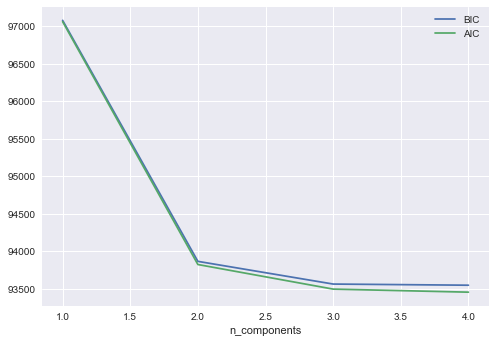

In [133]:
n_components = np.arange(1, 5)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(la)
          for n in n_components]

plt.plot(n_components, [m.bic(la) for m in models], label='BIC')
plt.plot(n_components, [m.aic(la) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [144]:
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(load_atribute_train_0, load_target_train)
labels = gmm.predict(load_atribute_test_0)

In [153]:
# probs = gmm.predict_proba(la)
# print(probs[:500].round(3)) 

In [145]:
data_new = gmm.sample(15000)

In [151]:
pd.DataFrame(data_new[0]), pd.DataFrame(data_new[1])

(            0         1         2         3         4         5         6    \
 0      1.002599 -0.848932 -0.312057 -0.699038  1.256654 -0.810920 -0.660470   
 1     -1.209951  1.050964  0.198600  0.679225  0.597144  0.078934  0.376718   
 2      1.008404 -1.946463  0.790822  1.552052 -0.014581 -1.187581  1.318712   
 3     -1.634467 -0.672599  0.456015  1.196457  1.028399  1.432235 -1.107032   
 4     -1.131196  0.755389  0.547115  0.469124 -0.489770  0.998500  0.165562   
 ...         ...       ...       ...       ...       ...       ...       ...   
 14995 -0.295741 -0.006015  0.368451 -2.696687  0.119772  0.362178 -0.063534   
 14996 -0.856602 -0.007511 -2.741078 -1.133401 -0.219585 -1.048892 -0.987164   
 14997 -0.191461 -0.006459 -0.220184  0.284878  0.679158 -0.055039 -1.416600   
 14998 -0.619825 -0.008718  0.418135 -0.082756  0.785442 -0.345441  0.288930   
 14999 -0.893042 -0.007925  1.111482  0.914092  1.721269  0.793526 -1.868342   
 
             7         8         9    

In [159]:
mu, sigma = np.mean(la), np.std(la)# mean and standard deviation

s = np.random.normal(mu, sigma, 15000)

In [178]:
pd.DataFrame(data_new[0]).shape, df.shape

((15000, 801), (15000, 801))

In [181]:

# df = pd.DataFrame(data_new[0]).merge(pd.DataFrame(data_new[1]), how='left')
df = pd.merge(pd.DataFrame(data_new[0]), pd.DataFrame(data_new[1]), left_index=True, right_index=True)


In [182]:
df

0_x         1         2         3         4         5         6  \
0      1.002599 -0.848932 -0.312057 -0.699038  1.256654 -0.810920 -0.660470   
1     -1.209951  1.050964  0.198600  0.679225  0.597144  0.078934  0.376718   
2      1.008404 -1.946463  0.790822  1.552052 -0.014581 -1.187581  1.318712   
3     -1.634467 -0.672599  0.456015  1.196457  1.028399  1.432235 -1.107032   
4     -1.131196  0.755389  0.547115  0.469124 -0.489770  0.998500  0.165562   
...         ...       ...       ...       ...       ...       ...       ...   
14995 -0.295741 -0.006015  0.368451 -2.696687  0.119772  0.362178 -0.063534   
14996 -0.856602 -0.007511 -2.741078 -1.133401 -0.219585 -1.048892 -0.987164   
14997 -0.191461 -0.006459 -0.220184  0.284878  0.679158 -0.055039 -1.416600   
14998 -0.619825 -0.008718  0.418135 -0.082756  0.785442 -0.345441  0.288930   
14999 -0.893042 -0.007925  1.111482  0.914092  1.721269  0.793526 -1.868342   

              7         8         9  ...       792       793       794  \
0      1.758754  1.341194 -1.854337  ... -0.333721  0.209393  0.165568   
1     -0.368525  2.283667 -1.050285  ...  0.906605  0.808734  0.811171   
2     -0.860622 -1.279943 -0.746295  ...  1.756550  1.820435  1.646802   
3      1.102406 -0.791066 -0.841445  ... -0.730563 -0.282669  0.168878   
4     -0.229196  0.633227  0.973117  ...  0.267809  0.098902 -0.085464   
...         ...       ...       ...  ...       ...       ...       ...   
14995 -0.592865  0.396366 -0.439460  ...  0.857863  0.588666  0.386934   
14996 -1.000114 -1.531220  1.870421  ... -1.269346 -1.619721 -1.648254   
14997 -0.844678 -2.718849 -1.062062  ...  1.243280  1.592100  1.488511   
14998  1.126204  0.121652 -2.943965  ...  0.719615  0.846494  0.643870   
14999  1.041046 -0.856565  0.646267  ...  1.122408  0.974541  0.674021   

            795       796       797       798       799       800  0_y  
0      0.082448 -0.057267 -0.099702  0.938752 -0.685640 -0.333976    0  
1      0.931812  0.926671  0.779341  0.125373  1.247355  0.513767    0  
2      1.429429  0.805403  0.353239 -0.607483  0.065678 -0.327784    0  
3      0.631507  0.864657  0.864932  0.564605 -1.292673  1.575329    0  
4     -0.079302 -0.109809 -0.054801  0.542806 -2.201236  1.024947    0  
...         ...       ...       ...       ...       ...       ...  ...  
14995  0.104559 -0.015000 -0.258039 -0.866030  0.744068 -0.881185    1  
14996 -1.760378 -1.989280 -1.964299 -0.682183  0.751670 -1.296557    1  
14997  1.058040  0.699478  0.597455 -1.359035 -0.107265 -1.331440    1  
14998  0.500535  0.222759 -0.119224 -0.552760  0.256236 -1.146860    1  
14999  0.168464 -0.149071 -0.435319 -1.781374  0.341283 -1.339195    1  

[15000 rows x 802 columns]

In [154]:
probs = gmm.predict_proba(data_new[0])

In [156]:
gmm.get_params(deep=True)

{'covariance_type': 'full',
 'init_params': 'kmeans',
 'max_iter': 100,
 'means_init': None,
 'n_components': 2,
 'n_init': 1,
 'precisions_init': None,
 'random_state': 0,
 'reg_covar': 1e-06,
 'tol': 0.001,
 'verbose': 0,
 'verbose_interval': 10,
 'warm_start': False,
 'weights_init': None}

In [117]:
df_data_load['cluster']=labels
df_data_load_distribution_0 = df_data_load[df_data_load["cluster"]==0]
df_data_load_distribution_1 = df_data_load[df_data_load["cluster"]==1]